## Library

In [1]:
import os
import dill
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
from datetime import datetime as dt
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 10000)
MAX_YEAR = CURRENT_YEAR + 100                     # What year to end the run on? (CURRENT_YEAR defined in utils.py)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/pasta')  # Cache generated in "(1B) Minimal Menace Anchors" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/pasta.sqcache.npy'))))
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

Cache from: 2024-06-13 16:16:12.820657


{1: 24.4,
 5: 25.6,
 10: 26.2,
 20: 27.1,
 30: 28.2,
 40: 29.8,
 50: 31.6,
 60: 33.3,
 70: 35.2,
 80: 37.5,
 90: 41.0,
 95: 43.8,
 99: 49.4}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "(3A) Initial TAI Spend Model" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/initial_pay.sqcache.npy'))))
initial_pay = [round(p, 1) for p in initial_pay]
sq.get_percentiles(initial_pay)

Cache from: 2024-08-31 10:35:15.197057


{1: 8.2,
 5: 8.4,
 10: 8.5,
 20: 8.6,
 30: 8.7,
 40: 8.8,
 50: 8.9,
 60: 9.0,
 70: 9.1,
 80: 9.3,
 90: 9.5,
 95: 9.7,
 99: 10.1}

In [5]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/nonscaling_delays.dill'))))

delay

Cache from: 2024-06-13 23:05:32.824387


{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=2.52, lognorm_sd=1.31, norm_mean=0.8, norm_sd=0.49)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=8.08, lognorm_sd=6.42, norm_mean=1.84, norm_sd=0.7) (version 0.28-dev1)},
 'infra': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> lognorm(lognorm_mean=7.56, lognorm_sd=3.93, norm_mean=1.9, norm_sd=0.49) (version 0.28-dev1)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.45, lognorm_sd=2.42, norm_mean=1.04, norm_sd=0.63)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=5.86, lognorm_sd=2.22, norm_mean=1.7, norm_sd=0.37) (version 0.28-dev1)}}

In [6]:
def wildeford_max_gdp_frac():
    gdp_frac = sq.mixture([[0.9, sq.lognorm(1/500, 1/100)],
                           [0.1, sq.lognorm(1/100, 1/20)]])
    percent_spent_on_compute = sq.lognorm(0.7, 0.99, lclip=0.1, rclip=0.999)
    percent_spent_on_largest_model = sq.lognorm(0.01, 0.8, rclip=0.999)
    compute_frac = gdp_frac * percent_spent_on_compute * percent_spent_on_largest_model
    return {'total_frac': gdp_frac, 'compute_frac': compute_frac}


base_flop_per_dollar = sq.lognorm(18.2, 19.4) # https://forum.effectivealtruism.org/posts/ccw9v9giKxg8nyLhp/xpt-forecasts-on-some-biological-anchors-inputs
# I'd use 1.43e18 FLOP/$ if renting cloud compute for training (significantly higher for serving a product, and significantly lower if using your own compute -- but then the number depends on how long you amortize it over).
# Source: If renting cloud compute, pricing seems to be $1.89-2.40 per H100 hour. (Jack Clark says $2 with bulk discounts.) Going with $2/hr, with the H100's 1.98e15 FLOP/s (FP8) and assuming 40% utilization (for training), that's 1.98e15*.4*60*60/2 = 1.43e18 FLOP/$.
# https://jack-clark.net/2024/03/28/what-does-1025-versus-1026-mean/ and https://gpus.llm-utils.org/h100-gpu-cloud-availability-and-pricing/
flop_frontier_penalty = sq.norm(0, 1)

# https://docs.google.com/spreadsheets/d/1cLzO_tX9b4z6URKLFvzc0MtsN4GrftkFZuv1bCxeWVY/edit#gid=2058539694
variables = {'initial_gdp': 23.32*T * sq.lognorm(1.02, 1.03) * sq.lognorm(1.02, 1.03) * sq.lognorm(1.02, 1.03),
             'tai_flop_size': np.array(tai_flop_size),
             'algo_doubling_rate_max': sq.lognorm(0.5, 3),
             'algo_doubling_rate_min': sq.lognorm(0.5, 2),
             'min_reduction': 2,
             'max_reduction': sq.lognorm(3, 15),
             'initial_flop_per_dollar': base_flop_per_dollar - flop_frontier_penalty,
             'flop_halving_rate': sq.norm(2, 3),      # https://epochai.org/blog/trends-in-gpu-price-performance and https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.norm(21, 26),  # https://epochai.org/blog/predicting-gpu-performance and https://asteriskmag.com/issues/03/the-transistor-cliff
             'initial_pay': np.array(initial_pay),
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': lambda: wildeford_max_gdp_frac()['compute_frac'],
             'spend_doubling_time': sq.lognorm(0.5, 2, lclip=0.1),
             'nonscaling_delay': delay}

variables

{'initial_gdp': <Distribution> 23320000000000.0 * lognorm(lognorm_mean=1.02, lognorm_sd=0.0, norm_mean=0.02, norm_sd=0.0) * lognorm(lognorm_mean=1.02, lognorm_sd=0.0, norm_mean=0.02, norm_sd=0.0) * lognorm(lognorm_mean=1.02, lognorm_sd=0.0, norm_mean=0.02, norm_sd=0.0) (version 0.28-dev3),
 'tai_flop_size': array([36.1, 34.8, 42.7, ..., 28.1, 31.4, 45.4]),
 'algo_doubling_rate_max': <Distribution> lognorm(lognorm_mean=1.42, lognorm_sd=0.83, norm_mean=0.2, norm_sd=0.54) (version 0.28-dev3),
 'algo_doubling_rate_min': <Distribution> lognorm(lognorm_mean=1.09, lognorm_sd=0.48, norm_mean=0.0, norm_sd=0.42) (version 0.28-dev3),
 'min_reduction': 2,
 'max_reduction': <Distribution> lognorm(lognorm_mean=7.56, lognorm_sd=3.93, norm_mean=1.9, norm_sd=0.49) (version 0.28-dev3),
 'initial_flop_per_dollar': <Distribution> lognorm(lognorm_mean=18.79, lognorm_sd=0.36, norm_mean=2.93, norm_sd=0.02) - norm(mean=0.5, sd=0.3) (version 0.28-dev3),
 'flop_halving_rate': <Distribution> norm(mean=2.5, sd=0.

## GDP Frac

### GDP

In [7]:
gdp_samples = sq.sample(variables['initial_gdp'], n=5000)
{k: numerize(v) for k, v in sq.get_percentiles(gdp_samples).items()}

{1: '24.8 trillion',
 5: '24.9 trillion',
 10: '24.9 trillion',
 20: '25.0 trillion',
 30: '25.0 trillion',
 40: '25.1 trillion',
 50: '25.1 trillion',
 60: '25.1 trillion',
 70: '25.2 trillion',
 80: '25.2 trillion',
 90: '25.3 trillion',
 95: '25.3 trillion',
 99: '25.4 trillion'}

#### Total % of GDP spent on entire project

In [8]:
gdp_frac_samples = sq.sample(lambda: wildeford_max_gdp_frac()['total_frac'], verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 18693.48it/s]


{1: 0.00152,
 5: 0.00207,
 10: 0.00248,
 20: 0.0031,
 30: 0.00363,
 40: 0.0042,
 50: 0.00478,
 60: 0.00547,
 70: 0.00644,
 80: 0.00793,
 90: 0.01254,
 95: 0.02191,
 99: 0.04103}

In [9]:
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

{1: '0.152%',
 5: '0.207%',
 10: '0.248%',
 20: '0.31%',
 30: '0.363%',
 40: '0.42%',
 50: '0.478%',
 60: '0.547%',
 70: '0.644%',
 80: '0.793%',
 90: '1.254%',
 95: '2.191%',
 99: '4.103%'}

In [10]:
gdp_frac_samples = gdp_samples * gdp_frac_samples
{k: numerize(v) for k, v in sq.get_percentiles(gdp_frac_samples).items()}

{1: '38.1 billion',
 5: '52.0 billion',
 10: '62.2 billion',
 20: '77.8 billion',
 30: '91.1 billion',
 40: '105.4 billion',
 50: '119.9 billion',
 60: '137.3 billion',
 70: '161.8 billion',
 80: '199.2 billion',
 90: '313.5 billion',
 95: '549.4 billion',
 99: '1.0 trillion'}

#### Total % of GDP spent on compute for largest model

In [11]:
gdp_frac_samples = sq.sample(lambda: wildeford_max_gdp_frac()['compute_frac'], verbose=True, n=5000)
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 6091.25it/s]


{1: '0.001%',
 5: '0.004%',
 10: '0.006%',
 20: '0.011%',
 30: '0.018%',
 40: '0.026%',
 50: '0.039%',
 60: '0.055%',
 70: '0.081%',
 80: '0.131%',
 90: '0.254%',
 95: '0.423%',
 99: '1.188%'}

In [12]:
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

{1: '0.001%',
 5: '0.004%',
 10: '0.006%',
 20: '0.011%',
 30: '0.018%',
 40: '0.026%',
 50: '0.039%',
 60: '0.055%',
 70: '0.081%',
 80: '0.131%',
 90: '0.254%',
 95: '0.423%',
 99: '1.188%'}

In [13]:
gdp_frac_samples = gdp_samples * gdp_frac_samples
{k: numerize(v) for k, v in sq.get_percentiles(gdp_frac_samples).items()}

{1: '323.1 million',
 5: '883.5 million',
 10: '1.5 billion',
 20: '2.8 billion',
 30: '4.4 billion',
 40: '6.6 billion',
 50: '9.7 billion',
 60: '13.8 billion',
 70: '20.3 billion',
 80: '33.0 billion',
 90: '64.1 billion',
 95: '106.2 billion',
 99: '299.6 billion'}

In [14]:
def model():
    frac = wildeford_max_gdp_frac()
    return frac['total_frac'] / frac['compute_frac']

sq.get_percentiles(sq.sample(model, verbose=True, n=5000), digits=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 3667.93it/s]


{1: 0.3,
 5: 1.0,
 10: 1.6,
 20: 3.3,
 30: 5.5,
 40: 8.3,
 50: 12.6,
 60: 19.7,
 70: 31.9,
 80: 53.4,
 90: 115.1,
 95: 211.9,
 99: 720.2}

## Run Wildeford timelines model



## SAMPLE RUN 1 ##

In this simulation:
* It takes 25.0 log FLOP (~10.0 septillion) for transformative capabilities.
* Every 5.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~7.2 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 23.7 log FLOP (~467.3 sextillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~626.2 million).
* This doubles every 1.5 year to a max of 0.333413% of GDP (initially ~83.2 billion 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 25.0 logFLOP which costs 6.1 log 2025$USD to buy vs. WTP at 8.8 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 8 years (total delay 8 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 8 mo

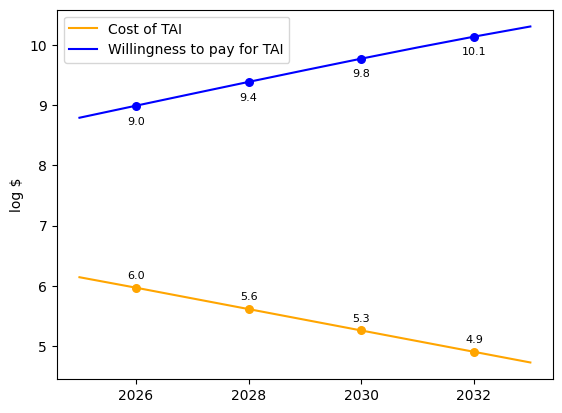



## SAMPLE RUN 2 ##

In this simulation:
* It takes 26.8 log FLOP (~631.0 septillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.0 log FLOP (~1.0 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 24.6 log FLOP (~4.1 septillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~1.1 billion).
* This doubles every 0.9 year to a max of 0.025611% of GDP (initially ~6.5 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 26.8 logFLOP which costs 8.8 log 2025$USD to buy vs. WTP at 9.0 (buys 27.0 log FLOP or 27.0 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 7 years (total delay 7 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 7 more y

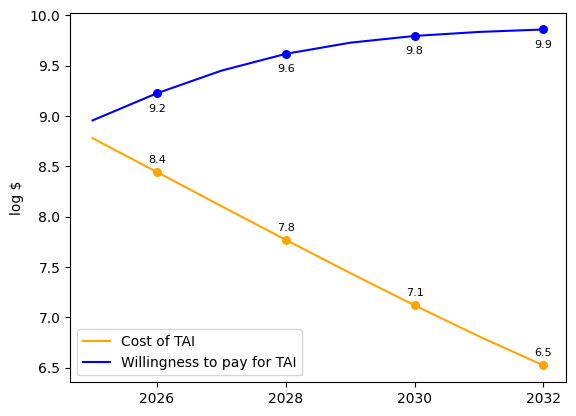



## SAMPLE RUN 3 ##

In this simulation:
* It takes 38.0 log FLOP (~100.0 thousand decillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.1 log FLOP (~1.2 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 24.9 log FLOP (~7.7 septillion) per 2025$USD.
* We are initially willing to pay 8.2 log 2025$USD (~158.0 million).
* This doubles every 0.8 year to a max of 0.209579% of GDP (initially ~51.8 billion 2025$USD).
* GDP grows at a rate of 1.023x per year.
---
2025 - TAI takes 38.0 logFLOP which costs 19.9 log 2025$USD to buy vs. WTP at 8.2 (buys 26.3 log FLOP or 26.3 2025-log-eFLOP)
2026 - TAI takes 37.7 logFLOP which costs 19.5 log 2025$USD to buy vs. WTP at 8.6 (buys 26.7 log FLOP or 27.1 2025-log-eFLOP)
2027 - TAI takes 37.4 logFLOP which costs 19.1 log 2025$USD to buy vs. WTP at 8.9 (buys 27.2 log FLOP or 27.8 2025-log-eFLOP)
2028 - TAI takes 37.1 logFLOP whic

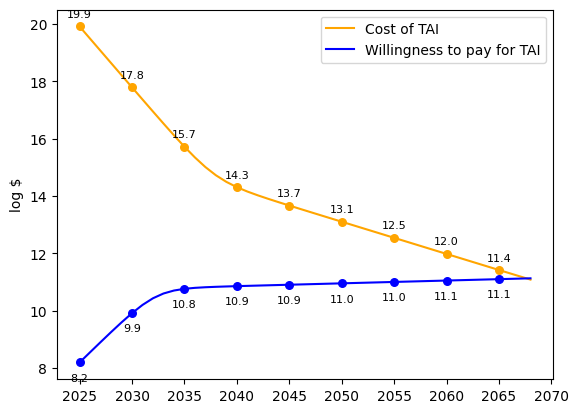



## RUN TIMELINES MODEL ##
Generating Bayes net with 12 cores...


10044it [00:12, 827.66it/s]                                                                                                                                                                                                                          


Shuffling data...
Writing data...
Waiting for other cores...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1365.63it/s]

...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!

## DISTRIBUTION OF TAI ARRIVAL DATE ##
['1%: 2026',
 '2%: 2027',
 '3%: 2027',
 '4%: 2028',
 '5%: 2028',
 '10%: 2030',
 '15%: 2031',
 '20%: 2032',
 '25%: 2033',
 '35%: 2036',
 '50%: 2043',
 '60%: 2049',
 '75%: 2076',
 '80%: 2122',
 '90%: >2125',
 '95%: >2125']


## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['1%: 1 years from now',
 '2%: 2 years from now',
 '3%: 2 years from now',
 '4%: 3 years from now',
 '5%: 3 years from now',
 '10%: 5 years from now',
 '15%: 6 years from now',
 '20%: 7 years from now',
 '25%: 8 years from now',
 '35%: 11 years from now',
 '50%: 18 years from now',
 '60%: 24 years from now',
 '75%: 51 years from now',
 '80%: 97 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
(Mean: 35 years from now)


## TAI ARRIVAL DATE BY BIN ##
2025-2026: 1.7%
2027-2029: 7.1%
2030-2034: 21.6%
2035-2039: 14.



## GDP Over Time ##
Year: 2025 - GDP log 2024$USD 13.4 (~25.1 trillion) 80% CI 13.4 (~25.0 trillion) - 13.4 (~25.2 trillion)
Year: 2026 - GDP log 2024$USD 13.4 (~25.7 trillion) 80% CI 13.4 (~25.4 trillion) - 13.4 (~26.0 trillion)
Year: 2027 - GDP log 2024$USD 13.4 (~26.3 trillion) 80% CI 13.4 (~25.8 trillion) - 13.4 (~26.7 trillion)
Year: 2028 - GDP log 2024$USD 13.4 (~26.8 trillion) 80% CI 13.4 (~26.3 trillion) - 13.4 (~27.5 trillion)
Year: 2029 - GDP log 2024$USD 13.4 (~27.5 trillion) 80% CI 13.4 (~26.7 trillion) - 13.5 (~28.3 trillion)
Year: 2030 - GDP log 2024$USD 13.4 (~28.1 trillion) 80% CI 13.4 (~27.1 trillion) - 13.5 (~29.1 trillion)
Year: 2031 - GDP log 2024$USD 13.5 (~28.7 trillion) 80% CI 13.4 (~27.6 trillion) - 13.5 (~30.0 trillion)
Year: 2032 - GDP log 2024$USD 13.5 (~29.4 trillion) 80% CI 13.4 (~28.0 trillion) - 13.5 (~30.8 trillion)
Year: 2033 - GDP log 2024$USD 13.5 (~30.0 trillion) 80% CI 13.5 (~28.5 trillion) - 13.5 (~31.7 trillion)
Year: 2034 - GDP log 2024$USD 13.

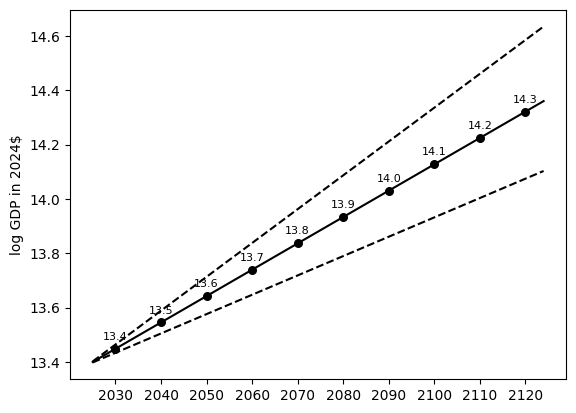

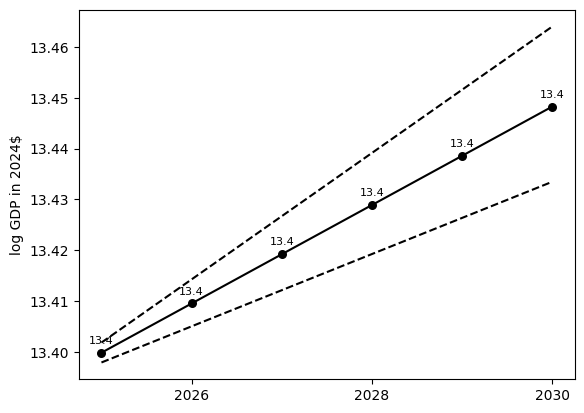



## Willingness to Pay Over Time (Total infrastructure) ##
Year: 2025 - willingness log 2024$USD per year for total infrastructure 10.3 (~18.4 billion) 80% CI 9.5 (~3.5 billion) - 11.2 (~151.0 billion)
Year: 2026 - willingness log 2024$USD per year for total infrastructure 10.5 (~34.3 billion) 80% CI 9.9 (~7.9 billion) - 11.4 (~239.3 billion)
Year: 2027 - willingness log 2024$USD per year for total infrastructure 10.8 (~60.8 billion) 80% CI 10.2 (~14.9 billion) - 11.6 (~373.0 billion)
Year: 2028 - willingness log 2024$USD per year for total infrastructure 11.0 (~99.6 billion) 80% CI 10.4 (~22.4 billion) - 11.8 (~567.9 billion)
Year: 2029 - willingness log 2024$USD per year for total infrastructure 11.2 (~147.9 billion) 80% CI 10.4 (~27.9 billion) - 11.9 (~836.8 billion)
Year: 2030 - willingness log 2024$USD per year for total infrastructure 11.3 (~197.1 billion) 80% CI 10.5 (~31.0 billion) - 12.1 (~1.2 trillion)
Year: 2031 - willingness log 2024$USD per year for total infrastructure 1

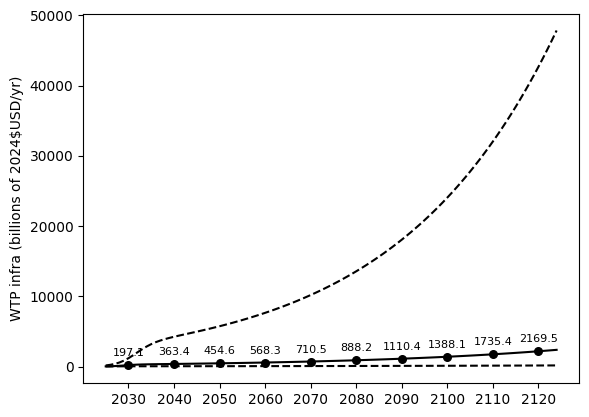

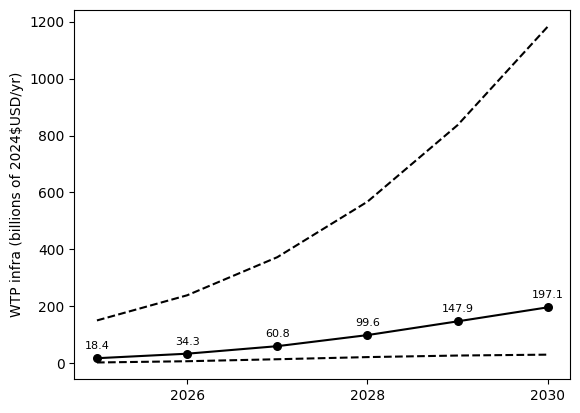



## Willingness to Pay Over Time (Largest single model) ##
Year: 2025 - willingness log 2024$USD per year for largest single model 8.9 (~738.0 million) 80% CI 8.5 (~351.9 million) - 9.3 (~1.9 billion)
Year: 2026 - willingness log 2024$USD per year for largest single model 9.1 (~1.4 billion) 80% CI 8.9 (~790.0 million) - 9.5 (~3.0 billion)
Year: 2027 - willingness log 2024$USD per year for largest single model 9.4 (~2.4 billion) 80% CI 9.2 (~1.5 billion) - 9.7 (~4.7 billion)
Year: 2028 - willingness log 2024$USD per year for largest single model 9.6 (~4.0 billion) 80% CI 9.4 (~2.2 billion) - 9.9 (~7.1 billion)
Year: 2029 - willingness log 2024$USD per year for largest single model 9.8 (~5.9 billion) 80% CI 9.4 (~2.8 billion) - 10.0 (~10.5 billion)
Year: 2030 - willingness log 2024$USD per year for largest single model 9.9 (~7.9 billion) 80% CI 9.5 (~3.1 billion) - 10.2 (~14.8 billion)
Year: 2031 - willingness log 2024$USD per year for largest single model 10.0 (~9.6 billion) 80% CI 9.5

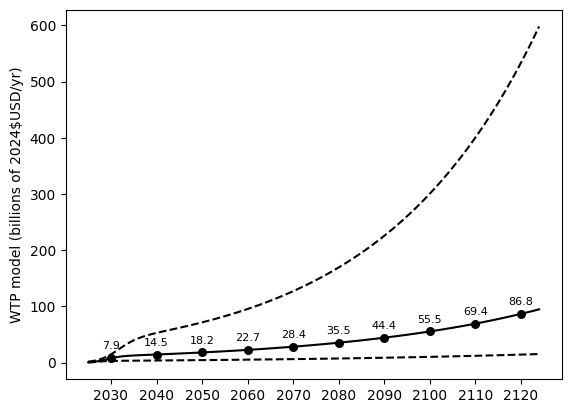

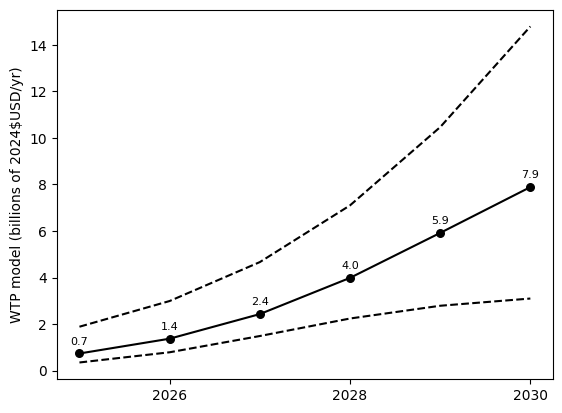



## Actual FLOP Needed to Make TAI (Given Algorithmic Progress) ##
Year: 2025 - logFLOP needed for TAI 31.4 (~25.1 nonillion) 80% CI 27.0 (~1.0 octillion) - 37.0 (~10.0 thousand decillion)
Year: 2026 - logFLOP needed for TAI 31.1 (~12.8 nonillion) 80% CI 26.6 (~420.6 septillion) - 36.8 (~6.1 thousand decillion)
Year: 2027 - logFLOP needed for TAI 30.8 (~6.6 nonillion) 80% CI 26.3 (~178.6 septillion) - 36.6 (~3.7 thousand decillion)
Year: 2028 - logFLOP needed for TAI 30.5 (~3.4 nonillion) 80% CI 25.9 (~79.2 septillion) - 36.4 (~2.3 thousand decillion)
Year: 2029 - logFLOP needed for TAI 30.3 (~1.8 nonillion) 80% CI 25.6 (~38.4 septillion) - 36.1 (~1.4 thousand decillion)
Year: 2030 - logFLOP needed for TAI 30.0 (~1.0 nonillion) 80% CI 25.3 (~21.7 septillion) - 35.9 (~860.7 decillion)
Year: 2031 - logFLOP needed for TAI 29.8 (~648.4 octillion) 80% CI 25.2 (~14.8 septillion) - 35.7 (~529.6 decillion)
Year: 2032 - logFLOP needed for TAI 29.7 (~450.2 octillion) 80% CI 25.1 (~12.0 septilli

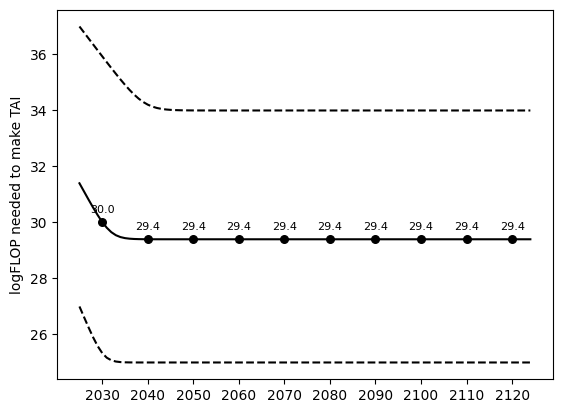

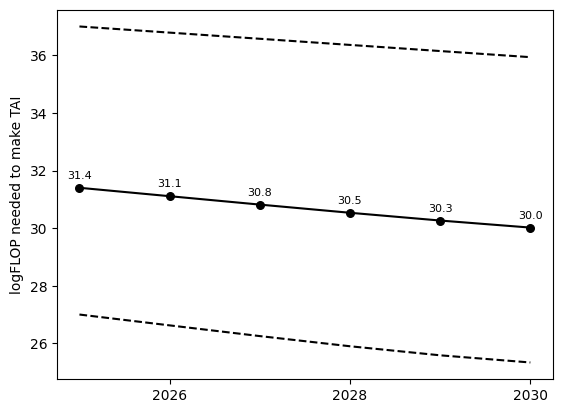



## FLOP per Dollar (Given Declining Costs) ##
Year: 2025 - logFLOP per 2024$1USD 18.3 (~2.0 quintillion) 80% CI 17.9 (~774.2 quadrillion) - 18.7 (~4.8 quintillion)
Year: 2026 - logFLOP per 2024$1USD 18.4 (~2.7 quintillion) 80% CI 18.0 (~1.1 quintillion) - 18.8 (~6.2 quintillion)
Year: 2027 - logFLOP per 2024$1USD 18.5 (~3.5 quintillion) 80% CI 18.2 (~1.4 quintillion) - 18.9 (~8.0 quintillion)
Year: 2028 - logFLOP per 2024$1USD 18.7 (~4.6 quintillion) 80% CI 18.3 (~1.9 quintillion) - 19.0 (~10.2 quintillion)
Year: 2029 - logFLOP per 2024$1USD 18.8 (~6.1 quintillion) 80% CI 18.4 (~2.6 quintillion) - 19.1 (~13.1 quintillion)
Year: 2030 - logFLOP per 2024$1USD 18.9 (~8.0 quintillion) 80% CI 18.6 (~3.6 quintillion) - 19.2 (~16.9 quintillion)
Year: 2031 - logFLOP per 2024$1USD 19.0 (~10.6 quintillion) 80% CI 18.7 (~4.8 quintillion) - 19.3 (~21.7 quintillion)
Year: 2032 - logFLOP per 2024$1USD 19.1 (~14.0 quintillion) 80% CI 18.8 (~6.6 quintillion) - 19.4 (~27.9 quintillion)
Year: 2033 - lo

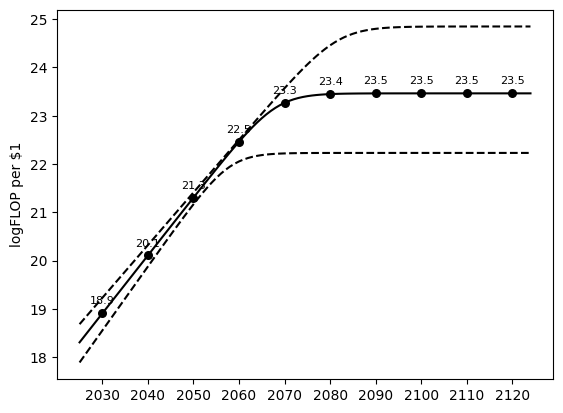

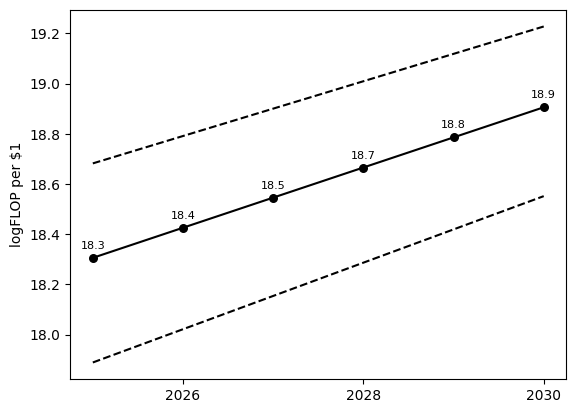



## Max Possible OOM Reduction in TAI FLOP Size ##
TAI log FLOP 20 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 21 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 22 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 23 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 24 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 25 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 26 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 27 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 28 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 29 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 30 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 31 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 32 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 33 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2

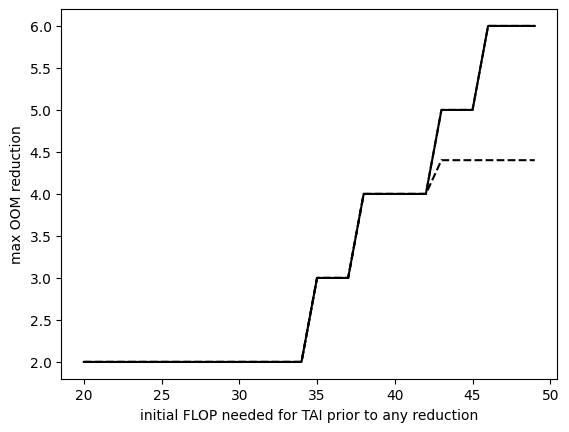



## Halving time (years) of compute requirements ##
TAI log FLOP 20 -> algo doubling rate 1.24yrs (80% CI: 2.02 to 2.02)
TAI log FLOP 21 -> algo doubling rate 1.24yrs (80% CI: 2.02 to 2.02)
TAI log FLOP 22 -> algo doubling rate 1.24yrs (80% CI: 2.02 to 2.02)
TAI log FLOP 23 -> algo doubling rate 1.24yrs (80% CI: 2.02 to 2.02)
TAI log FLOP 24 -> algo doubling rate 1.24yrs (80% CI: 2.02 to 2.02)
TAI log FLOP 25 -> algo doubling rate 1.24yrs (80% CI: 2.02 to 2.02)
TAI log FLOP 26 -> algo doubling rate 1.24yrs (80% CI: 2.02 to 2.02)
TAI log FLOP 27 -> algo doubling rate 1.24yrs (80% CI: 2.02 to 2.02)
TAI log FLOP 28 -> algo doubling rate 1.24yrs (80% CI: 2.02 to 2.02)
TAI log FLOP 29 -> algo doubling rate 1.24yrs (80% CI: 2.02 to 2.02)
TAI log FLOP 30 -> algo doubling rate 1.24yrs (80% CI: 2.02 to 2.02)
TAI log FLOP 31 -> algo doubling rate 1.0yrs (80% CI: 1.52 to 1.52)
TAI log FLOP 32 -> algo doubling rate 1.0yrs (80% CI: 1.02 to 1.02)
TAI log FLOP 33 -> algo doubling rate 1.0yrs (80% CI

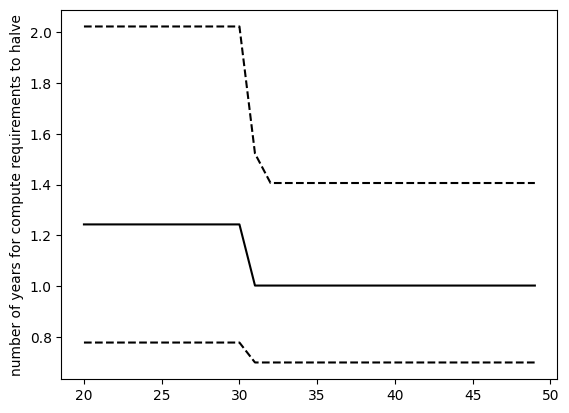



## Dollars Needed to Buy TAI (Given Algorithmic Progress and Decline in Cost per FLOP) ##
Year: 2025 - 13.1 log 2024$USD to buy TAI (~12.4 trillion) 80% CI 9.1 (~1.3 billion) - 18.3 (~2.1 quintillion)
Year: 2026 - 12.7 log 2024$USD to buy TAI (~4.8 trillion) 80% CI 8.6 (~400.3 million) - 18.0 (~989.4 quadrillion)
Year: 2027 - 12.3 log 2024$USD to buy TAI (~1.9 trillion) 80% CI 8.1 (~125.3 million) - 17.7 (~470.6 quadrillion)
Year: 2028 - 11.9 log 2024$USD to buy TAI (~736.1 billion) 80% CI 7.6 (~40.9 million) - 17.4 (~224.0 quadrillion)
Year: 2029 - 11.5 log 2024$USD to buy TAI (~300.3 billion) 80% CI 7.2 (~14.6 million) - 17.0 (~106.7 quadrillion)
Year: 2030 - 11.1 log 2024$USD to buy TAI (~129.7 billion) 80% CI 6.8 (~6.1 million) - 16.7 (~50.9 quadrillion)
Year: 2031 - 10.8 log 2024$USD to buy TAI (~61.1 billion) 80% CI 6.5 (~3.1 million) - 16.4 (~24.4 quadrillion)
Year: 2032 - 10.5 log 2024$USD to buy TAI (~32.2 billion) 80% CI 6.3 (~1.8 million) - 16.1 (~11.7 quadrillion)
Year: 2

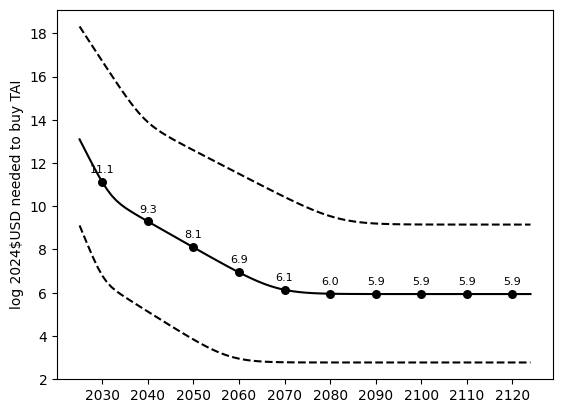

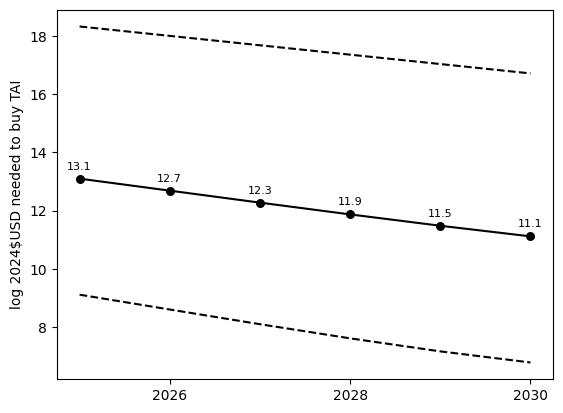



## Actual FLOP at Max Spend ##
Year: 2025 - max log FLOP 27.2 (~1.5 octillion) 80% CI 26.4 (~272.4 septillion) - 28.0 (~9.1 octillion)
Year: 2026 - max log FLOP 27.6 (~3.7 octillion) 80% CI 26.9 (~829.9 septillion) - 28.3 (~18.5 octillion)
Year: 2027 - max log FLOP 27.9 (~8.5 octillion) 80% CI 27.3 (~2.1 octillion) - 28.6 (~37.1 octillion)
Year: 2028 - max log FLOP 28.3 (~18.5 octillion) 80% CI 27.6 (~4.3 octillion) - 28.9 (~72.6 octillion)
Year: 2029 - max log FLOP 28.6 (~36.1 octillion) 80% CI 27.9 (~7.3 octillion) - 29.1 (~137.5 octillion)
Year: 2030 - max log FLOP 28.8 (~63.5 octillion) 80% CI 28.0 (~11.0 octillion) - 29.4 (~249.8 octillion)
Year: 2031 - max log FLOP 29.0 (~101.4 octillion) 80% CI 28.2 (~15.8 octillion) - 29.6 (~431.9 octillion)
Year: 2032 - max log FLOP 29.2 (~151.1 octillion) 80% CI 28.3 (~22.1 octillion) - 29.9 (~708.4 octillion)
Year: 2033 - max log FLOP 29.3 (~215.4 octillion) 80% CI 28.5 (~30.6 octillion) - 30.0 (~1.1 nonillion)
Year: 2034 - max log FLOP 29

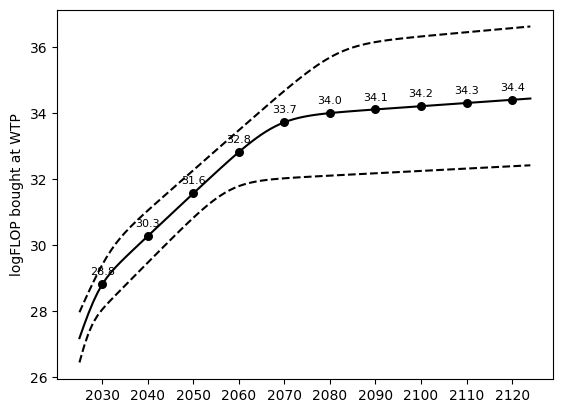

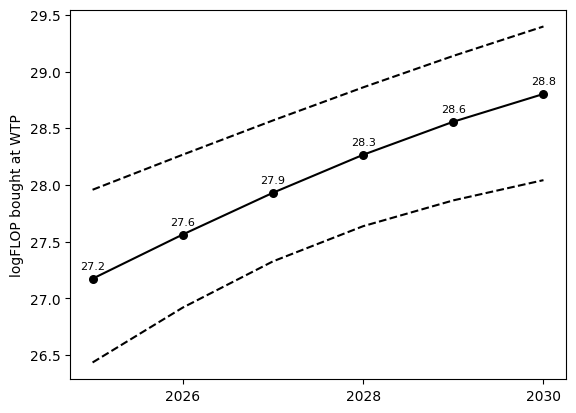



## Effective 2024-FLOP at Max Spend (given algorithmic progress and decline in $/FLOP) ##
Year: 2025 - max log effective 2024-FLOP 27.2 (~1.5 octillion) 80% CI 26.4 (~272.4 septillion) - 28.0 (~9.1 octillion)
Year: 2026 - max log effective 2024-FLOP 27.9 (~7.2 octillion) 80% CI 27.1 (~1.3 octillion) - 28.7 (~49.6 octillion)
Year: 2027 - max log effective 2024-FLOP 28.5 (~32.7 octillion) 80% CI 27.7 (~5.5 octillion) - 29.4 (~266.5 octillion)
Year: 2028 - max log effective 2024-FLOP 29.1 (~136.0 octillion) 80% CI 28.3 (~18.2 octillion) - 30.1 (~1.4 nonillion)
Year: 2029 - max log effective 2024-FLOP 29.7 (~494.9 octillion) 80% CI 28.7 (~49.0 octillion) - 30.8 (~6.8 nonillion)
Year: 2030 - max log effective 2024-FLOP 30.2 (~1.5 nonillion) 80% CI 29.1 (~116.1 octillion) - 31.5 (~30.9 nonillion)
Year: 2031 - max log effective 2024-FLOP 30.6 (~3.9 nonillion) 80% CI 29.4 (~254.7 octillion) - 32.1 (~118.9 nonillion)
Year: 2032 - max log effective 2024-FLOP 30.9 (~8.4 nonillion) 80% CI 29.7 (

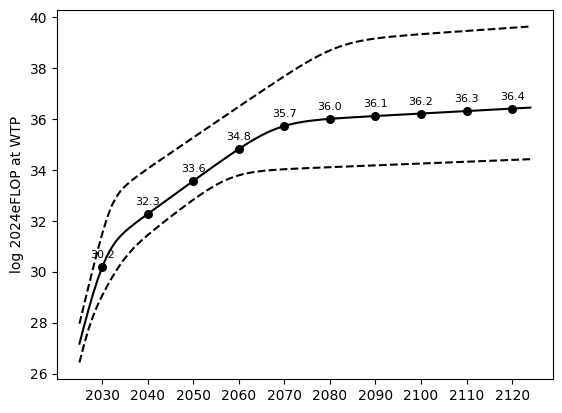

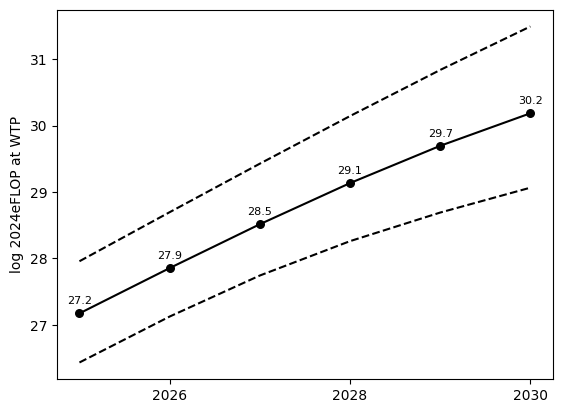


## TAI FLOP SIZE ##
{1: 24.297,
 5: 25.6,
 10: 26.2,
 20: 27.0,
 30: 28.07,
 40: 29.96,
 50: 31.4,
 60: 33.3,
 70: 35.2,
 80: 37.0,
 90: 40.410000000000004,
 95: 43.205,
 99: 48.5}


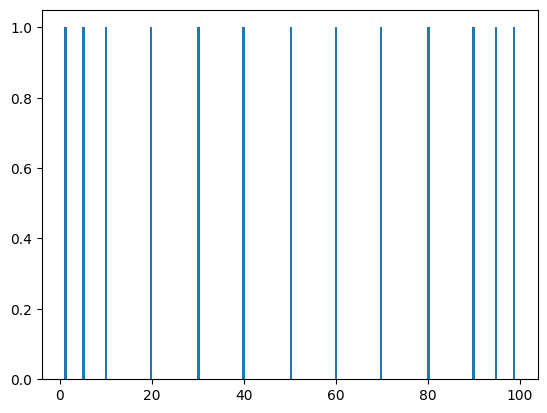



## MIN REDUCTION: 2 ##

## MAX REDUCTION ##
{1: 2.400251634110307,
 5: 3.0554203730616543,
 10: 3.564992045674888,
 20: 4.4015740545836355,
 30: 5.158473056153624,
 40: 5.820638823846135,
 50: 6.67779551107639,
 60: 7.5593565234577955,
 70: 8.651764936894791,
 80: 10.227561938144037,
 90: 12.04986142568353,
 95: 15.393350583181068,
 99: 21.482270592701354}


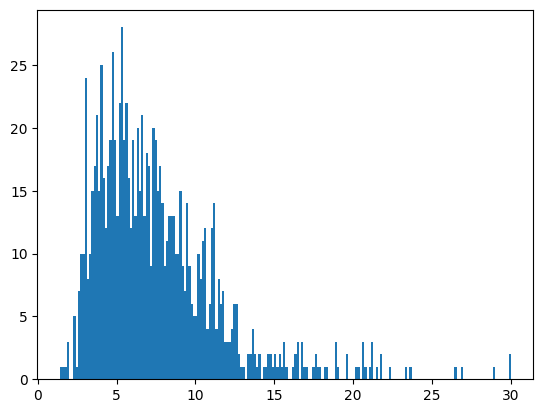



## MIN ALGO DOUBLING RATE ##
{1: 0.3812442096312946,
 5: 0.4898636801344636,
 10: 0.5856833437950795,
 20: 0.700204280902336,
 30: 0.800367956624734,
 40: 0.8934092470196797,
 50: 1.0028661539612238,
 60: 1.1044512083992577,
 70: 1.2353422374648184,
 80: 1.4063594765665817,
 90: 1.7363026117283704,
 95: 2.0681174039407475,
 99: 2.5082715801148554}


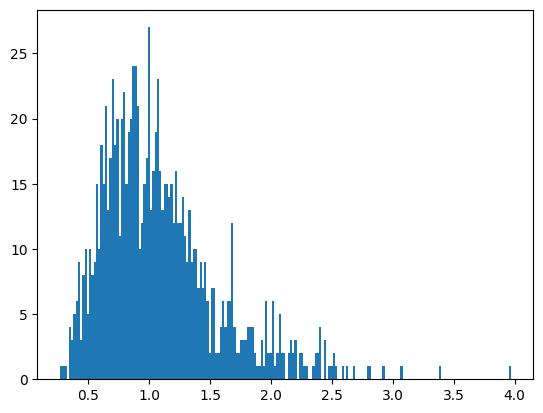



## MAX ALGO DOUBLING RATE ##
{1: 0.35354418390449494,
 5: 0.5013625710410474,
 10: 0.5998405429950826,
 20: 0.7786361170996668,
 30: 0.938045703438466,
 40: 1.0904331772238456,
 50: 1.2434561156746249,
 60: 1.4505738400359158,
 70: 1.684272257572087,
 80: 2.022286910673908,
 90: 2.4594833055025456,
 95: 3.018388867818906,
 99: 3.993779235283258}


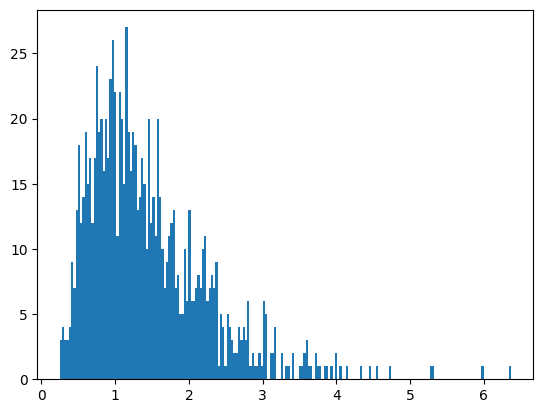



## INITIAL FLOP PER DOLLAR ##
{1: 17.173227057780625,
 5: 17.486142943115244,
 10: 17.668747048749587,
 20: 17.88887419515843,
 30: 18.037050007353187,
 40: 18.169393147005607,
 50: 18.305818264928014,
 60: 18.414860519829613,
 70: 18.53851234878246,
 80: 18.68216866593467,
 90: 18.878642790921308,
 95: 19.032425794534973,
 99: 19.327254202816864}


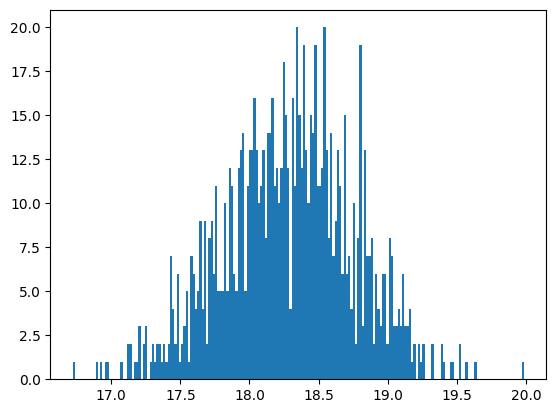



## FLOP HALVING RATE ##
{1: 1.8221962086979566,
 5: 2.0043867635491472,
 10: 2.115800585990931,
 20: 2.2706352069232945,
 30: 2.3588451826615575,
 40: 2.443185903456364,
 50: 2.5087117290278975,
 60: 2.5843288959040986,
 70: 2.678375375349475,
 80: 2.7587381316467376,
 90: 2.8734731339542674,
 95: 2.9809085623215754,
 99: 3.205895078445441}


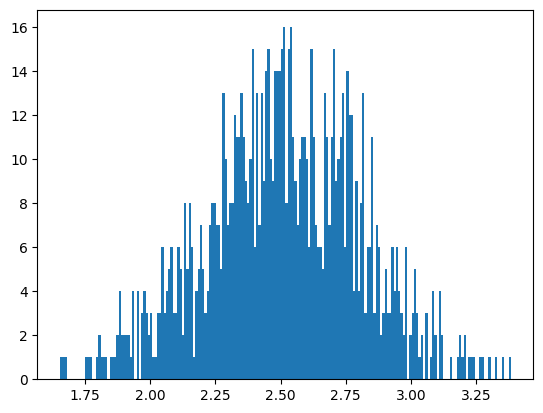



## MAX FLOP PER DOLLAR ##
{1: 19.919288560391607,
 5: 21.031862870113656,
 10: 21.5953447711515,
 20: 22.22930123960877,
 30: 22.632332333019754,
 40: 23.133335023544753,
 50: 23.463076499765524,
 60: 23.825389873711188,
 70: 24.29939733817358,
 80: 24.84838591456511,
 90: 25.453562773441845,
 95: 26.05465244164646,
 99: 27.030288247998072}


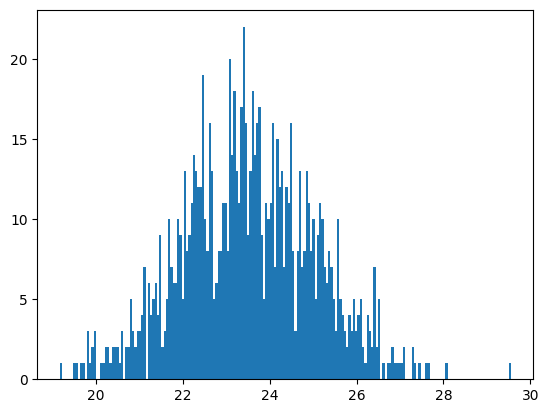



## INITIAL PAY ##
{1: 8.2,
 5: 8.4,
 10: 8.5,
 20: 8.6,
 30: 8.7,
 40: 8.8,
 50: 8.9,
 60: 9.0,
 70: 9.1,
 80: 9.3,
 90: 9.510000000000002,
 95: 9.7,
 99: 10.2}


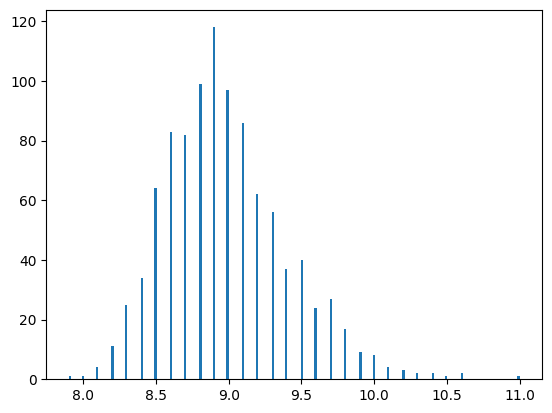



## INITIAL GDP ##
{1: 24824191504975.516,
 5: 24896724285680.133,
 10: 24948145033317.457,
 20: 24996757990230.117,
 30: 25042785170207.11,
 40: 25072390043302.316,
 50: 25107681613643.746,
 60: 25146199567260.92,
 70: 25188241711846.04,
 80: 25223211738543.62,
 90: 25281834275631.645,
 95: 25319861084312.74,
 99: 25391414135004.965}


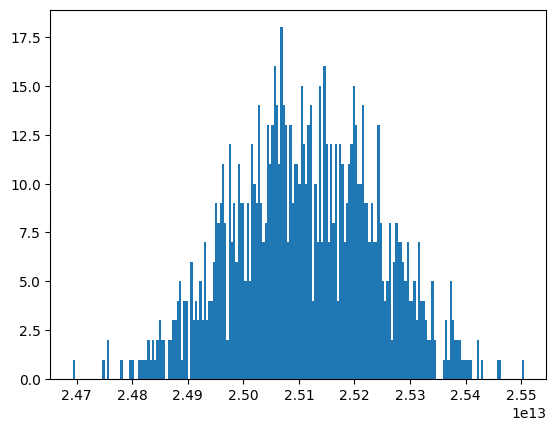



## GDP GROWTH ##
{1: 1.0052584715358484,
 5: 1.010466083426095,
 10: 1.0133526460144597,
 20: 1.016526421993804,
 30: 1.0187159972405,
 40: 1.0203792369333444,
 50: 1.0225773372697504,
 60: 1.0244742843875678,
 70: 1.0267135800658975,
 80: 1.0290812901922222,
 90: 1.0318359314832561,
 95: 1.0342578186413618,
 99: 1.0390542846446498}


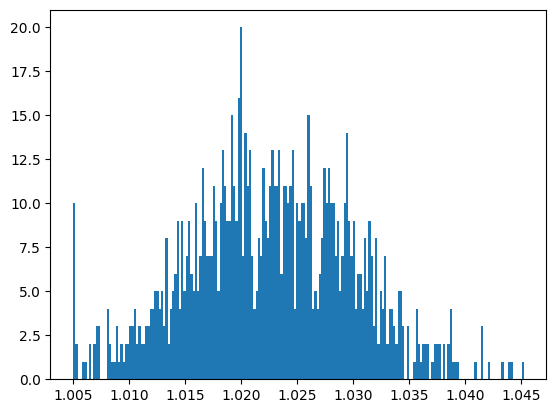



## MAX GDP FRAC ##
{1: 1.390991652814706e-05,
 5: 3.842754667464424e-05,
 10: 6.199632202450738e-05,
 20: 0.00012115771301486684,
 30: 0.0001828631213673684,
 40: 0.00027783569088658485,
 50: 0.0004144518043260894,
 60: 0.0005656833201536891,
 70: 0.0008641789338015495,
 80: 0.0013877984416290213,
 90: 0.0026647141303191304,
 95: 0.004450832332022528,
 99: 0.01387280449203137}


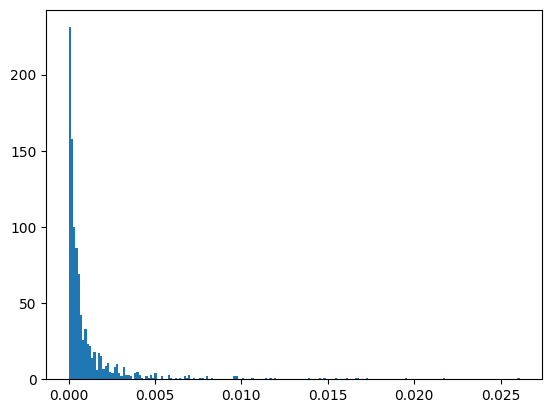



## SPEND DOUBLING TIME ##
{1: 0.38412425647316967,
 5: 0.509320090891063,
 10: 0.5765300750881319,
 20: 0.7059595129658148,
 30: 0.8093996551035516,
 40: 0.9064065171078353,
 50: 1.0112308267503662,
 60: 1.130245802540403,
 70: 1.2458156322214442,
 80: 1.4098501981535594,
 90: 1.7140665922570666,
 95: 2.014746041531425,
 99: 2.7069004547802917}


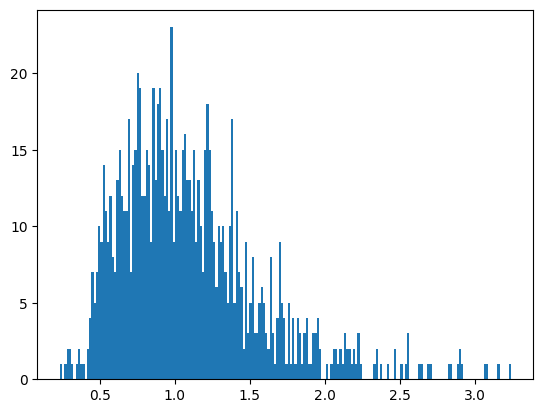





## Nonscaling delay ##
There are 3 ways a non-scaling delay could happen.
- algorithms: additional <Distribution> mixture
 - 0.9 weight on <Distribution> lognorm(lognorm_mean=2.52, lognorm_sd=1.31, norm_mean=0.8, norm_sd=0.49)
 - 0.1 weight on <Distribution> lognorm(lognorm_mean=8.08, lognorm_sd=6.42, norm_mean=1.84, norm_sd=0.7) years if it happens
{1: 1,
 5: 1,
 10: 1,
 20: 2,
 30: 2,
 40: 2,
 50: 2,
 60: 3,
 70: 3,
 80: 4,
 90: 5,
 95: 6,
 99: 18}
## Chance of nonscaling delay ##


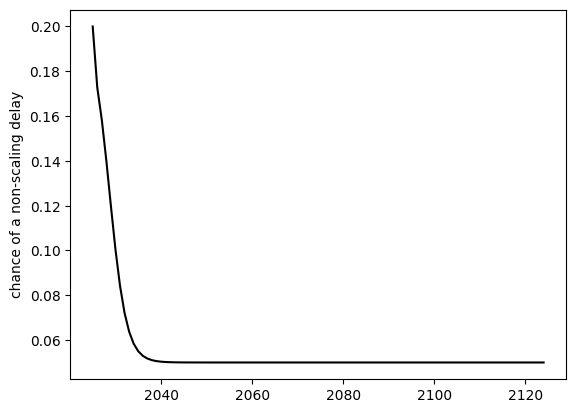

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 17%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 16%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 14%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 12%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 8%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 7%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2035 - c

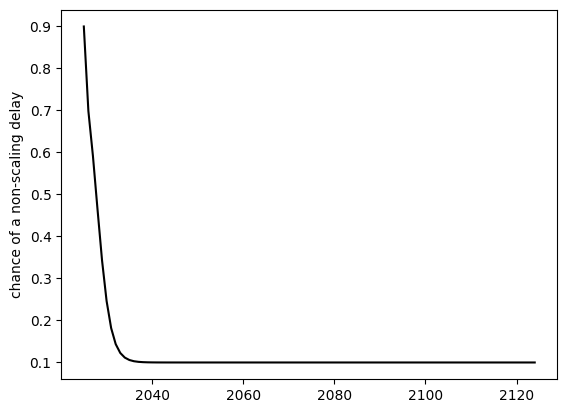

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 59%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 47%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 34%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 25%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 14%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 12%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 11%
Year: 2035

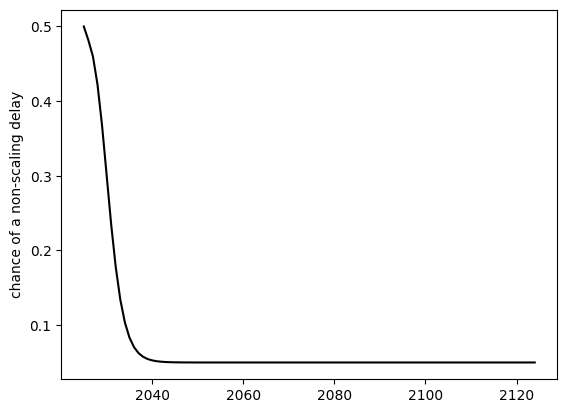

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 50%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 48%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 46%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 42%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 37%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 24%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 13%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2035

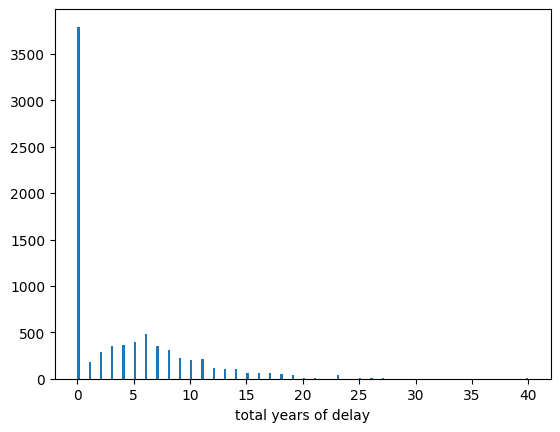

In [15]:
variables['RUNS'] = RUNS
variables['CURRENT_YEAR'] = CURRENT_YEAR
variables['MAX_YEAR'] = MAX_YEAR

run_timelines_model(variables,
                    cores=max(1, os.cpu_count() - 2),
                    runs=variables['RUNS'],
                    dump_cache_file='caches/tai_years')


-
-
## SAMPLE RUN 4 ##

In this simulation:
* It takes 25.9 log FLOP (~79.4 septillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.6 log FLOP (~386.3 quadrillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 24.8 log FLOP (~6.9 septillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~941.6 million).
* This doubles every 1.4 year to a max of 0.064103% of GDP (initially ~16.1 billion 2025$USD).
* GDP grows at a rate of 1.019x per year.
---
2025 - TAI takes 25.9 logFLOP which costs 8.3 log 2025$USD to buy vs. WTP at 8.9 (buys 26.5 log FLOP or 26.5 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 7 years (total delay 7 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling delay occured
-- -- this delay is 7 years (total delay 9 yea

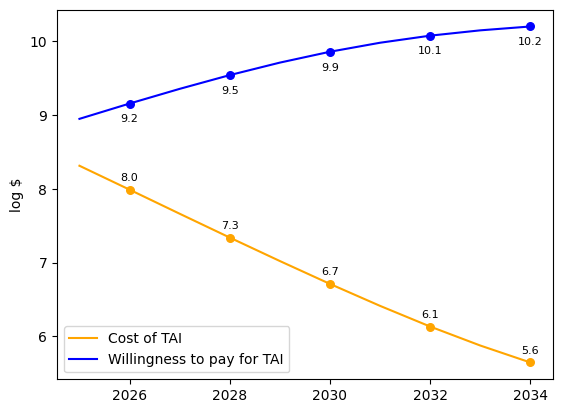

-
-
## SAMPLE RUN 5 ##

In this simulation:
* It takes 31.5 log FLOP (~31.6 nonillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~8.9 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 23.6 log FLOP (~398.8 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~964.2 million).
* This doubles every 0.4 year to a max of 0.106807% of GDP (initially ~26.9 billion 2025$USD).
* GDP grows at a rate of 1.028x per year.
---
2025 - TAI takes 31.5 logFLOP which costs 12.6 log 2025$USD to buy vs. WTP at 9.0 (buys 27.9 log FLOP or 27.9 2025-log-eFLOP)
2026 - TAI takes 31.3 logFLOP which costs 12.2 log 2025$USD to buy vs. WTP at 9.6 (buys 28.7 log FLOP or 28.9 2025-log-eFLOP)
2027 - TAI takes 31.1 logFLOP which costs 11.9 log 2025$USD to buy vs. WTP at 10.1 (buys 29.3 log FLOP or 29.7 2025-log-eFLOP)
2028 - TAI takes 30.9 logFLOP which cos

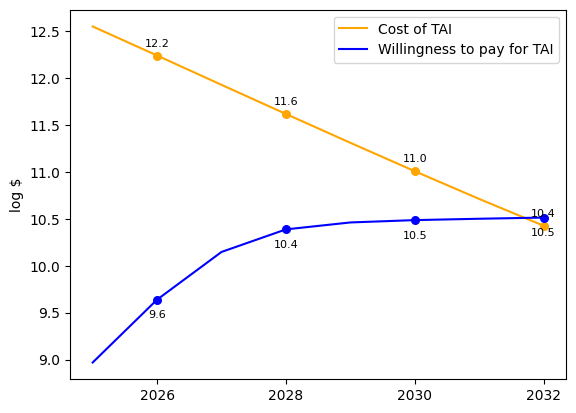

-
-
## SAMPLE RUN 6 ##

In this simulation:
* It takes 31.6 log FLOP (~39.8 nonillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.3 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 24.8 log FLOP (~6.1 septillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~328.4 million).
* This doubles every 0.8 year to a max of 0.002733% of GDP (initially ~685.1 million 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 31.6 logFLOP which costs 12.8 log 2025$USD to buy vs. WTP at 8.3 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
2026 - TAI takes 31.3 logFLOP which costs 12.3 log 2025$USD to buy vs. WTP at 8.6 (buys 27.5 log FLOP or 27.8 2025-log-eFLOP)
2027 - TAI takes 30.9 logFLOP which costs 11.9 log 2025$USD to buy vs. WTP at 8.7 (buys 27.8 log FLOP or 28.4 2025-log-eFLOP)
2028 - TAI takes 30.6 logFLOP which costs

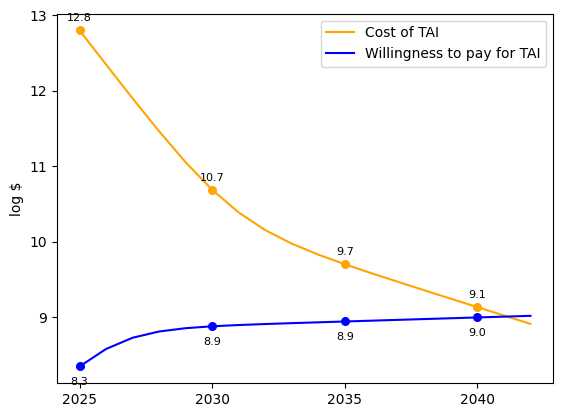

-
-
## SAMPLE RUN 7 ##

In this simulation:
* It takes 33.2 log FLOP (~1.6 decillion) for transformative capabilities.
* Every 1.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.7 log FLOP (~525.4 quadrillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~21.1 sextillion) per 2025$USD.
* We are initially willing to pay 8.1 log 2025$USD (~124.5 million).
* This doubles every 0.8 year to a max of 0.045633% of GDP (initially ~11.4 billion 2025$USD).
* GDP grows at a rate of 1.028x per year.
---
2025 - TAI takes 33.2 logFLOP which costs 15.5 log 2025$USD to buy vs. WTP at 8.1 (buys 25.8 log FLOP or 25.8 2025-log-eFLOP)
2026 - TAI takes 33.0 logFLOP which costs 15.2 log 2025$USD to buy vs. WTP at 8.5 (buys 26.3 log FLOP or 26.5 2025-log-eFLOP)
2027 - TAI takes 32.9 logFLOP which costs 14.9 log 2025$USD to buy vs. WTP at 8.9 (buys 26.8 log FLOP or 27.1 2025-log-eFLOP)
2028 - TAI takes 32.7 logFLOP which cost

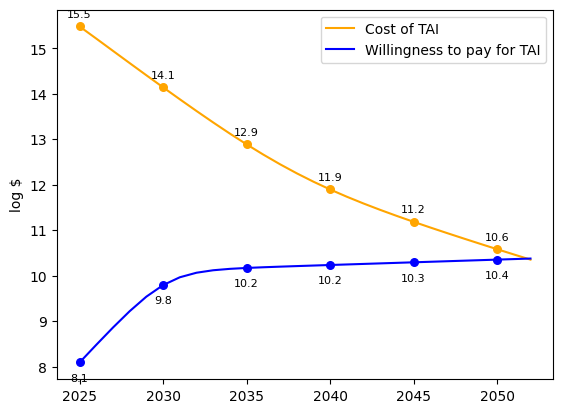

-
-
## SAMPLE RUN 8 ##

In this simulation:
* It takes 29.2 log FLOP (~158.5 octillion) for transformative capabilities.
* Every 4.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~4.9 quintillion) per 2025$USD.
* Every 2.0 years they get 2x cheaper, to a maximum of 24.8 log FLOP (~6.2 septillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~478.2 million).
* This doubles every 1.6 year to a max of 0.041741% of GDP (initially ~10.4 billion 2025$USD).
* GDP grows at a rate of 1.018x per year.
---
2025 - TAI takes 29.2 logFLOP which costs 10.5 log 2025$USD to buy vs. WTP at 8.7 (buys 27.3 log FLOP or 27.3 2025-log-eFLOP)
2026 - TAI takes 29.1 logFLOP which costs 10.3 log 2025$USD to buy vs. WTP at 8.8 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
2027 - TAI takes 29.1 logFLOP which costs 10.1 log 2025$USD to buy vs. WTP at 9.0 (buys 28.0 log FLOP or 28.1 2025-log-eFLOP)
2028 - TAI takes 29.0 logFLOP which costs

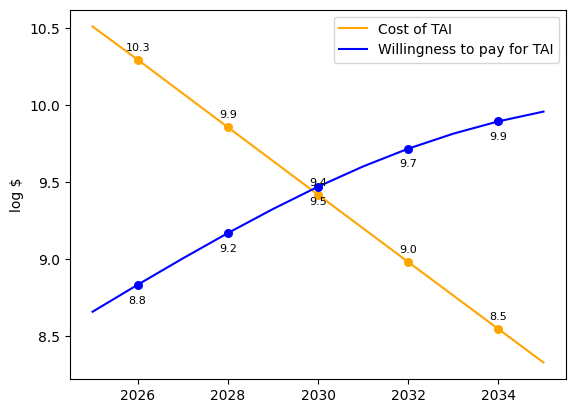

-
-
## SAMPLE RUN 9 ##

In this simulation:
* It takes 32.7 log FLOP (~501.2 nonillion) for transformative capabilities.
* Every 1.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.6 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 21.9 log FLOP (~7.2 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~996.1 million).
* This doubles every 0.5 year to a max of 0.018943% of GDP (initially ~4.8 billion 2025$USD).
* GDP grows at a rate of 1.02x per year.
---
2025 - TAI takes 32.7 logFLOP which costs 14.5 log 2025$USD to buy vs. WTP at 8.9 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
2026 - TAI takes 32.5 logFLOP which costs 14.2 log 2025$USD to buy vs. WTP at 9.3 (buys 27.7 log FLOP or 27.8 2025-log-eFLOP)
2027 - TAI takes 32.4 logFLOP which costs 13.9 log 2025$USD to buy vs. WTP at 9.6 (buys 28.0 log FLOP or 28.4 2025-log-eFLOP)
2028 - TAI takes 32.2 logFLOP which costs 1

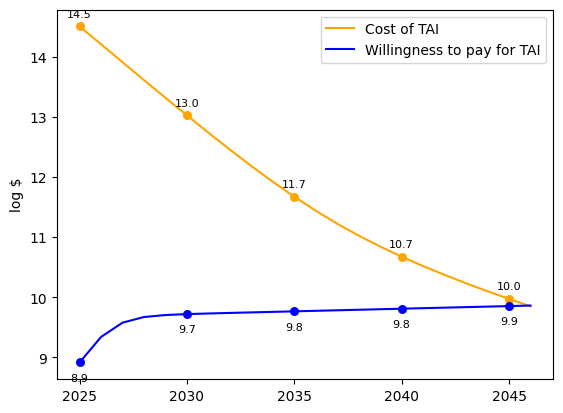

-
-
## SAMPLE RUN 10 ##

In this simulation:
* It takes 27.9 log FLOP (~7.9 octillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.6 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 23.3 log FLOP (~198.6 sextillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~724.4 million).
* This doubles every 1.0 year to a max of 0.010463% of GDP (initially ~2.6 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 27.9 logFLOP which costs 9.7 log 2025$USD to buy vs. WTP at 8.8 (buys 26.9 log FLOP or 26.9 2025-log-eFLOP)
2026 - TAI takes 27.6 logFLOP which costs 9.3 log 2025$USD to buy vs. WTP at 9.0 (buys 27.3 log FLOP or 27.6 2025-log-eFLOP)
2027 - TAI takes 27.3 logFLOP which costs 8.9 log 2025$USD to buy vs. WTP at 9.2 (buys 27.6 log FLOP or 28.1 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1583 ->

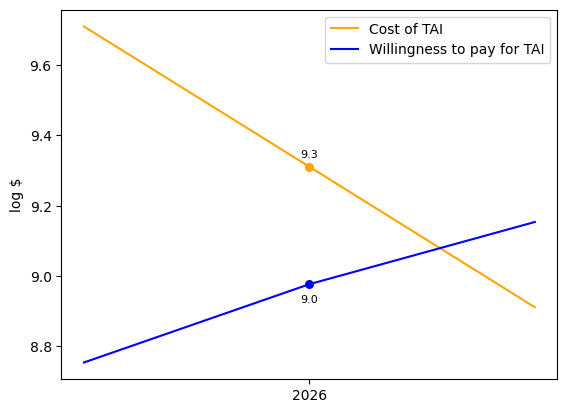

-
-
## SAMPLE RUN 11 ##

In this simulation:
* It takes 33.0 log FLOP (~1000.0 nonillion) for transformative capabilities.
* Every 0.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.3 log FLOP (~18.7 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~13.6 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~1.0 billion).
* This doubles every 1.3 year to a max of 0.00596% of GDP (initially ~1.5 billion 2025$USD).
* GDP grows at a rate of 1.024x per year.
---
2025 - TAI takes 33.0 logFLOP which costs 13.7 log 2025$USD to buy vs. WTP at 8.8 (buys 28.1 log FLOP or 28.1 2025-log-eFLOP)
2026 - TAI takes 32.4 logFLOP which costs 13.0 log 2025$USD to buy vs. WTP at 8.9 (buys 28.3 log FLOP or 28.9 2025-log-eFLOP)
2027 - TAI takes 31.8 logFLOP which costs 12.3 log 2025$USD to buy vs. WTP at 9.0 (buys 28.5 log FLOP or 29.7 2025-log-eFLOP)
2028 - TAI takes 31.4 logFLOP which costs

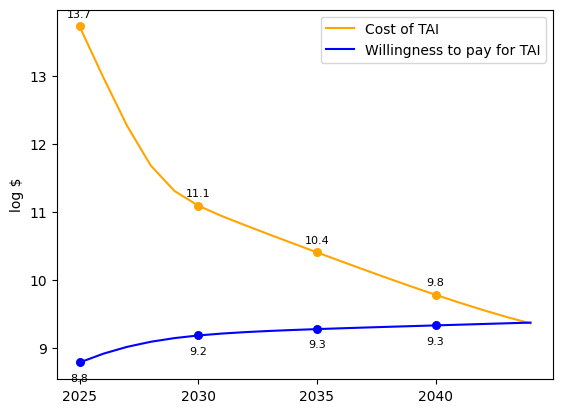

-
-
## SAMPLE RUN 12 ##

In this simulation:
* It takes 27.3 log FLOP (~2.0 octillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.2 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~7.0 sextillion) per 2025$USD.
* We are initially willing to pay 9.7 log 2025$USD (~5.3 billion).
* This doubles every 0.6 year to a max of 0.131542% of GDP (initially ~32.9 billion 2025$USD).
* GDP grows at a rate of 1.016x per year.
---
2025 - TAI takes 27.3 logFLOP which costs 8.8 log 2025$USD to buy vs. WTP at 9.7 (buys 28.2 log FLOP or 28.2 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 10 years (total delay 13 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling delay occured
-- --

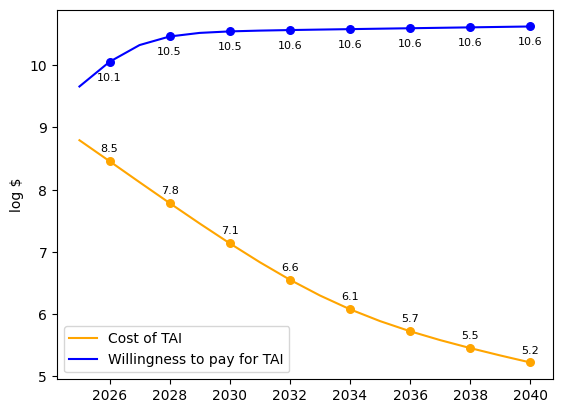

-
-
## SAMPLE RUN 13 ##

In this simulation:
* It takes 30.4 log FLOP (~2.5 nonillion) for transformative capabilities.
* Every 0.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.1 log FLOP (~12.1 quintillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 21.2 log FLOP (~1.7 sextillion) per 2025$USD.
* We are initially willing to pay 9.3 log 2025$USD (~1.9 billion).
* This doubles every 0.9 year to a max of 0.154539% of GDP (initially ~38.9 billion 2025$USD).
* GDP grows at a rate of 1.027x per year.
---
2025 - TAI takes 30.4 logFLOP which costs 11.3 log 2025$USD to buy vs. WTP at 9.3 (buys 28.3 log FLOP or 28.3 2025-log-eFLOP)
2026 - TAI takes 29.9 logFLOP which costs 10.7 log 2025$USD to buy vs. WTP at 9.6 (buys 28.8 log FLOP or 29.3 2025-log-eFLOP)
2027 - TAI takes 29.4 logFLOP which costs 10.1 log 2025$USD to buy vs. WTP at 9.9 (buys 29.2 log FLOP or 30.2 2025-log-eFLOP)
2028 - TAI takes 29.0 logFLOP which costs 9

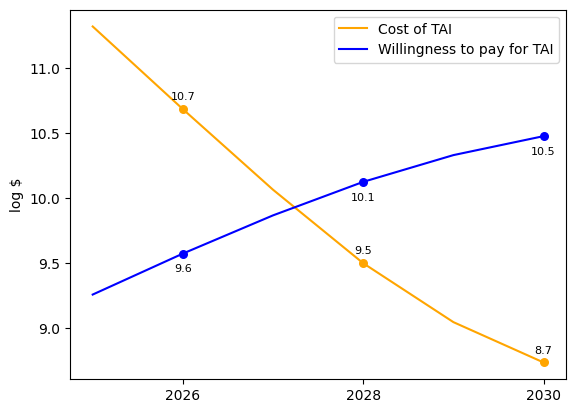

-
-
## SAMPLE RUN 14 ##

In this simulation:
* It takes 33.9 log FLOP (~7.9 decillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.6 log FLOP (~422.1 quadrillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 23.6 log FLOP (~368.2 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~382.3 million).
* This doubles every 0.5 year to a max of 0.038601% of GDP (initially ~9.6 billion 2025$USD).
* GDP grows at a rate of 1.024x per year.
---
2025 - TAI takes 33.9 logFLOP which costs 16.3 log 2025$USD to buy vs. WTP at 8.6 (buys 26.2 log FLOP or 26.2 2025-log-eFLOP)
2026 - TAI takes 33.7 logFLOP which costs 15.9 log 2025$USD to buy vs. WTP at 9.1 (buys 26.9 log FLOP or 27.1 2025-log-eFLOP)
2027 - TAI takes 33.5 logFLOP which costs 15.6 log 2025$USD to buy vs. WTP at 9.6 (buys 27.5 log FLOP or 27.9 2025-log-eFLOP)
2028 - TAI takes 33.3 logFLOP which cos

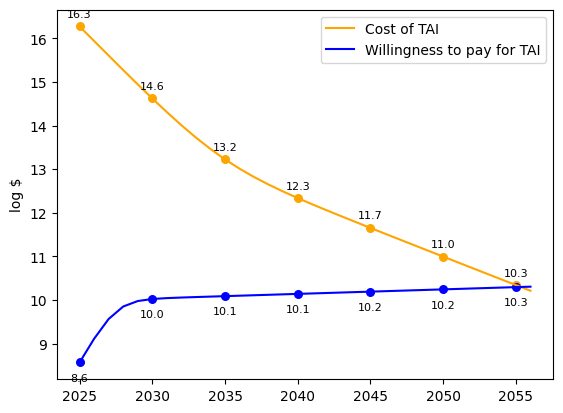

-
-
## SAMPLE RUN 15 ##

In this simulation:
* It takes 28.4 log FLOP (~25.1 octillion) for transformative capabilities.
* Every 1.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.3 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 24.6 log FLOP (~3.7 septillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~748.2 million).
* This doubles every 0.8 year to a max of 0.051332% of GDP (initially ~12.9 billion 2025$USD).
* GDP grows at a rate of 1.015x per year.
---
2025 - TAI takes 28.4 logFLOP which costs 9.9 log 2025$USD to buy vs. WTP at 8.8 (buys 27.4 log FLOP or 27.4 2025-log-eFLOP)
2026 - TAI takes 28.2 logFLOP which costs 9.6 log 2025$USD to buy vs. WTP at 9.2 (buys 27.9 log FLOP or 28.0 2025-log-eFLOP)
2027 - TAI takes 28.0 logFLOP which costs 9.3 log 2025$USD to buy vs. WTP at 9.5 (buys 28.3 log FLOP or 28.7 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1583 ->

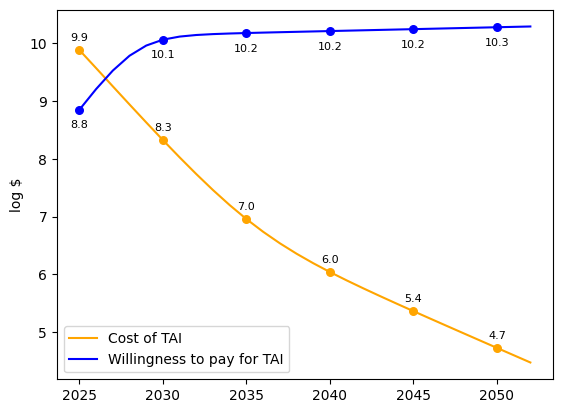

-
-
## SAMPLE RUN 16 ##

In this simulation:
* It takes 30.3 log FLOP (~2.0 nonillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.4 log FLOP (~248.6 quadrillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 21.0 log FLOP (~1.1 sextillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~546.4 million).
* This doubles every 0.8 year to a max of 0.006947% of GDP (initially ~1.8 billion 2025$USD).
* GDP grows at a rate of 1.033x per year.
---
2025 - TAI takes 30.3 logFLOP which costs 12.9 log 2025$USD to buy vs. WTP at 8.6 (buys 26.0 log FLOP or 26.0 2025-log-eFLOP)
2026 - TAI takes 30.0 logFLOP which costs 12.4 log 2025$USD to buy vs. WTP at 8.9 (buys 26.4 log FLOP or 26.7 2025-log-eFLOP)
2027 - TAI takes 29.6 logFLOP which costs 12.0 log 2025$USD to buy vs. WTP at 9.1 (buys 26.7 log FLOP or 27.4 2025-log-eFLOP)
2028 - TAI takes 29.3 logFLOP which costs

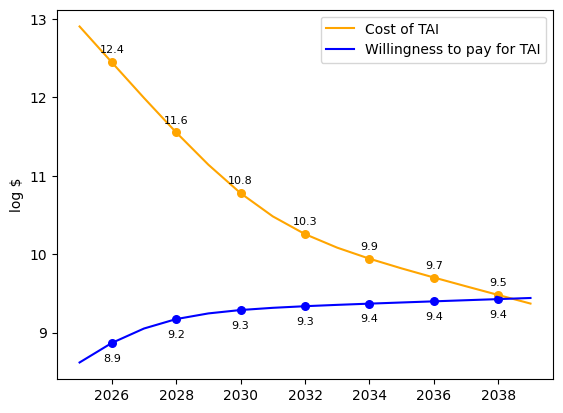

-
-
## SAMPLE RUN 17 ##

In this simulation:
* It takes 25.8 log FLOP (~63.1 septillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.8 log FLOP (~638.4 quadrillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~10.3 sextillion) per 2025$USD.
* We are initially willing to pay 8.3 log 2025$USD (~181.5 million).
* This doubles every 1.2 year to a max of 0.00113% of GDP (initially ~284.5 million 2025$USD).
* GDP grows at a rate of 1.037x per year.
---
2025 - TAI takes 25.8 logFLOP which costs 8.0 log 2025$USD to buy vs. WTP at 8.0 (buys 25.8 log FLOP or 25.8 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 7 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling delay occured


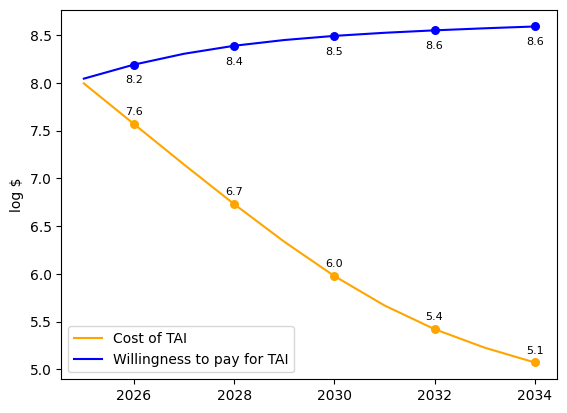

-
-
## SAMPLE RUN 18 ##

In this simulation:
* It takes 28.5 log FLOP (~31.6 octillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.0 log FLOP (~10.7 quintillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 24.6 log FLOP (~4.0 septillion) per 2025$USD.
* We are initially willing to pay 8.4 log 2025$USD (~227.6 million).
* This doubles every 0.6 year to a max of 0.009695% of GDP (initially ~2.4 billion 2025$USD).
* GDP grows at a rate of 1.011x per year.
---
2025 - TAI takes 28.5 logFLOP which costs 9.5 log 2025$USD to buy vs. WTP at 8.3 (buys 27.3 log FLOP or 27.3 2025-log-eFLOP)
2026 - TAI takes 28.1 logFLOP which costs 8.9 log 2025$USD to buy vs. WTP at 8.7 (buys 27.9 log FLOP or 28.3 2025-log-eFLOP)
2027 - TAI takes 27.7 logFLOP which costs 8.4 log 2025$USD to buy vs. WTP at 9.0 (buys 28.4 log FLOP or 29.1 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1583 ->

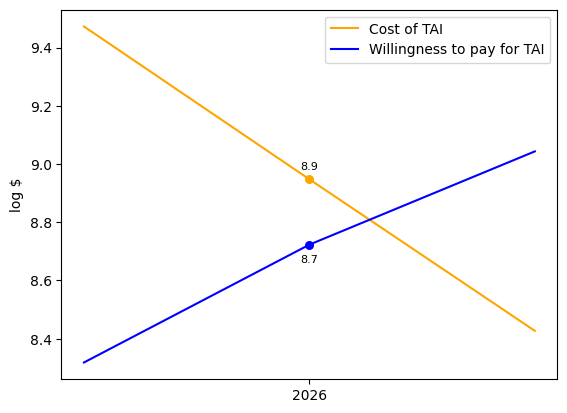

-
-
## SAMPLE RUN 19 ##

In this simulation:
* It takes 38.8 log FLOP (~631.0 thousand decillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 3.7 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.4 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~30.6 sextillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~748.4 million).
* This doubles every 1.1 year to a max of 0.00369% of GDP (initially ~921.6 million 2025$USD).
* GDP grows at a rate of 1.036x per year.
---
2025 - TAI takes 38.8 logFLOP which costs 20.4 log 2025$USD to buy vs. WTP at 8.6 (buys 27.0 log FLOP or 27.0 2025-log-eFLOP)
2026 - TAI takes 38.3 logFLOP which costs 19.8 log 2025$USD to buy vs. WTP at 8.8 (buys 27.3 log FLOP or 27.7 2025-log-eFLOP)
2027 - TAI takes 37.9 logFLOP which costs 19.3 log 2025$USD to buy vs. WTP at 8.9 (buys 27.5 log FLOP or 28.4 2025-log-eFLOP)
2028 - TAI takes 37.4 logFLO

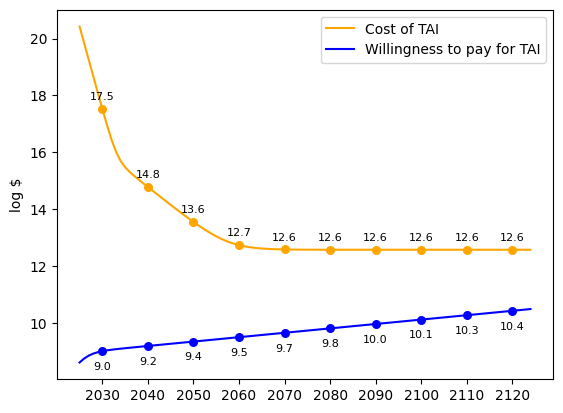

-
-
## SAMPLE RUN 20 ##

In this simulation:
* It takes 25.3 log FLOP (~20.0 septillion) for transformative capabilities.
* Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.1 log FLOP (~1.4 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~23.6 sextillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~313.6 million).
* This doubles every 0.4 year to a max of 0.151018% of GDP (initially ~37.8 billion 2025$USD).
* GDP grows at a rate of 1.018x per year.
---
2025 - TAI takes 25.3 logFLOP which costs 7.2 log 2025$USD to buy vs. WTP at 8.5 (buys 26.6 log FLOP or 26.6 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 7 years (total delay 7 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling issue did not occur
/!\ FLOP for TAI sufficient but needs 7 

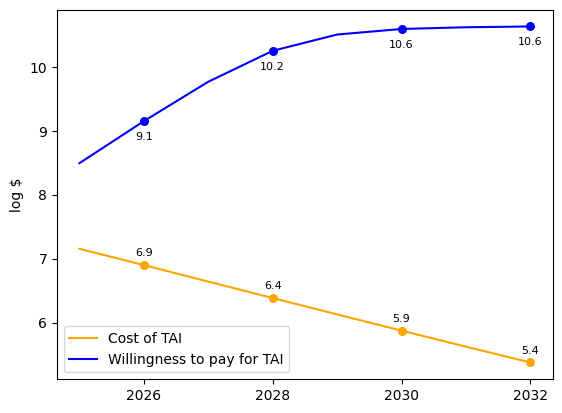

-
-
## SAMPLE RUN 21 ##

In this simulation:
* It takes 37.0 log FLOP (~10.0 thousand decillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 19.2 log FLOP (~16.7 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 21.1 log FLOP (~1.2 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~393.3 million).
* This doubles every 1.1 year to a max of 0.128428% of GDP (initially ~32.5 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 37.0 logFLOP which costs 17.8 log 2025$USD to buy vs. WTP at 8.6 (buys 27.8 log FLOP or 27.8 2025-log-eFLOP)
2026 - TAI takes 36.8 logFLOP which costs 17.5 log 2025$USD to buy vs. WTP at 8.9 (buys 28.2 log FLOP or 28.4 2025-log-eFLOP)
2027 - TAI takes 36.6 logFLOP which costs 17.1 log 2025$USD to buy vs. WTP at 9.1 (buys 28.6 log FLOP or 29.0 2025-log-eFLOP)
2028 - TAI takes 36.4 logFLOP w

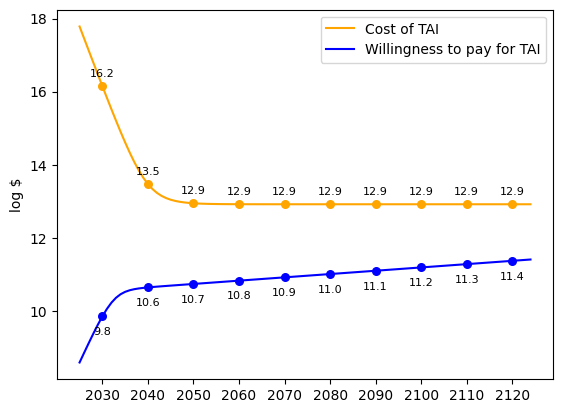

-
-
## SAMPLE RUN 22 ##

In this simulation:
* It takes 29.7 log FLOP (~501.2 octillion) for transformative capabilities.
* Every 2.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.1 log FLOP (~1.3 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 27.3 log FLOP (~2.0 octillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~711.3 million).
* This doubles every 1.8 year to a max of 0.027205% of GDP (initially ~6.8 billion 2025$USD).
* GDP grows at a rate of 1.032x per year.
---
2025 - TAI takes 29.7 logFLOP which costs 11.6 log 2025$USD to buy vs. WTP at 8.8 (buys 26.9 log FLOP or 26.9 2025-log-eFLOP)
2026 - TAI takes 29.6 logFLOP which costs 11.3 log 2025$USD to buy vs. WTP at 9.0 (buys 27.2 log FLOP or 27.3 2025-log-eFLOP)
2027 - TAI takes 29.4 logFLOP which costs 11.1 log 2025$USD to buy vs. WTP at 9.1 (buys 27.5 log FLOP or 27.7 2025-log-eFLOP)
2028 - TAI takes 29.3 logFLOP which costs 

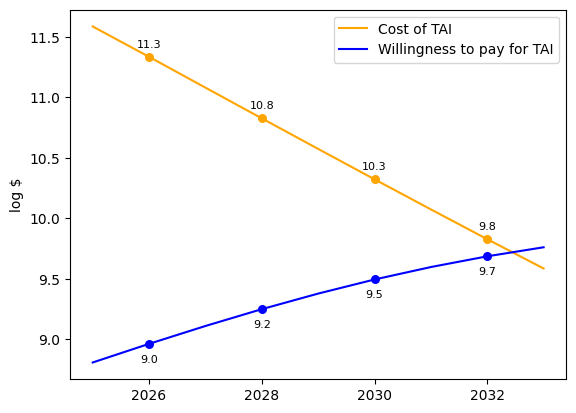

-
-
## SAMPLE RUN 23 ##

In this simulation:
* It takes 30.8 log FLOP (~6.3 nonillion) for transformative capabilities.
* Every 1.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~3.8 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 23.6 log FLOP (~427.7 sextillion) per 2025$USD.
* We are initially willing to pay 9.7 log 2025$USD (~4.9 billion).
* This doubles every 1.2 year to a max of 0.091796% of GDP (initially ~22.9 billion 2025$USD).
* GDP grows at a rate of 1.017x per year.
---
2025 - TAI takes 30.8 logFLOP which costs 12.2 log 2025$USD to buy vs. WTP at 9.6 (buys 28.2 log FLOP or 28.2 2025-log-eFLOP)
2026 - TAI takes 30.6 logFLOP which costs 11.9 log 2025$USD to buy vs. WTP at 9.8 (buys 28.5 log FLOP or 28.7 2025-log-eFLOP)
2027 - TAI takes 30.4 logFLOP which costs 11.6 log 2025$USD to buy vs. WTP at 10.0 (buys 28.8 log FLOP or 29.1 2025-log-eFLOP)
2028 - TAI takes 30.3 logFLOP which costs

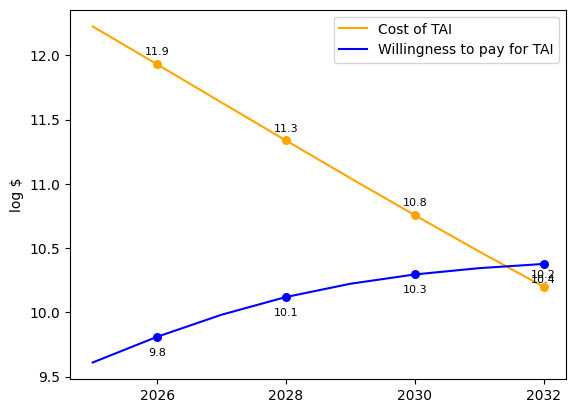

-
-
## SAMPLE RUN 24 ##

In this simulation:
* It takes 26.4 log FLOP (~251.2 septillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.1 log FLOP (~1.2 quintillion) per 2025$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 23.3 log FLOP (~214.4 sextillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~781.6 million).
* This doubles every 1.0 year to a max of 0.193793% of GDP (initially ~48.8 billion 2025$USD).
* GDP grows at a rate of 1.023x per year.
---
2025 - TAI takes 26.4 logFLOP which costs 8.3 log 2025$USD to buy vs. WTP at 8.9 (buys 27.0 log FLOP or 27.0 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 18 years (total delay 18 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 1

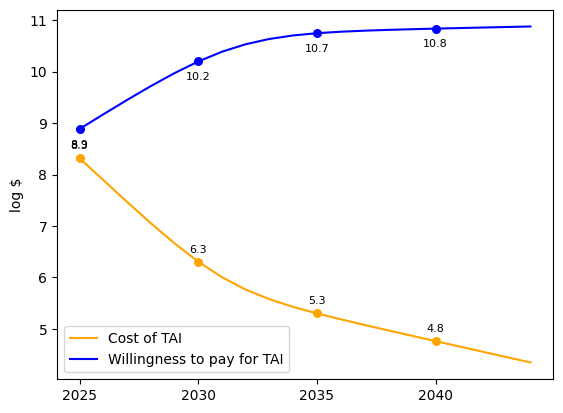

-
-
## SAMPLE RUN 25 ##

In this simulation:
* It takes 32.6 log FLOP (~398.1 nonillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.1 log FLOP (~1.3 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 21.3 log FLOP (~1.9 sextillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~314.9 million).
* This doubles every 1.0 year to a max of 0.306896% of GDP (initially ~76.4 billion 2025$USD).
* GDP grows at a rate of 1.019x per year.
---
2025 - TAI takes 32.6 logFLOP which costs 14.5 log 2025$USD to buy vs. WTP at 8.5 (buys 26.6 log FLOP or 26.6 2025-log-eFLOP)
2026 - TAI takes 32.3 logFLOP which costs 14.1 log 2025$USD to buy vs. WTP at 8.8 (buys 27.0 log FLOP or 27.3 2025-log-eFLOP)
2027 - TAI takes 32.0 logFLOP which costs 13.7 log 2025$USD to buy vs. WTP at 9.1 (buys 27.4 log FLOP or 28.0 2025-log-eFLOP)
2028 - TAI takes 31.7 logFLOP which cost

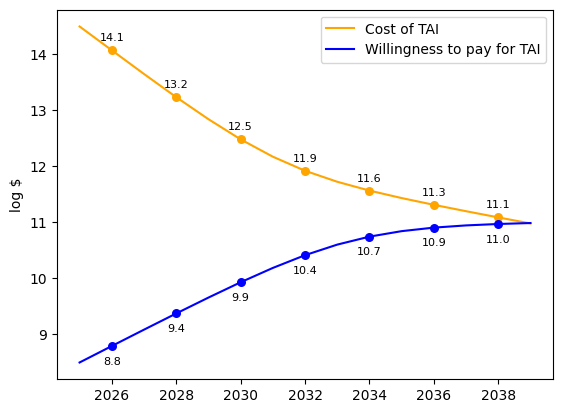

-
-
## SAMPLE RUN 26 ##

In this simulation:
* It takes 35.0 log FLOP (~100.0 decillion) for transformative capabilities.
* Every 0.6 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 17.7 log FLOP (~550.2 quadrillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~6.3 sextillion) per 2025$USD.
* We are initially willing to pay 9.7 log 2025$USD (~4.7 billion).
* This doubles every 0.9 year to a max of 0.04568% of GDP (initially ~11.5 billion 2025$USD).
* GDP grows at a rate of 1.029x per year.
---
2025 - TAI takes 35.0 logFLOP which costs 17.3 log 2025$USD to buy vs. WTP at 9.5 (buys 27.3 log FLOP or 27.3 2025-log-eFLOP)
2026 - TAI takes 34.5 logFLOP which costs 16.6 log 2025$USD to buy vs. WTP at 9.7 (buys 27.6 log FLOP or 28.1 2025-log-eFLOP)
2027 - TAI takes 33.9 logFLOP which costs 16.0 log 2025$USD to buy vs. WTP at 9.9 (buys 27.9 log FLOP or 28.9 2025-log-eFLOP)
2028 - TAI takes 33.4 logFLOP which costs

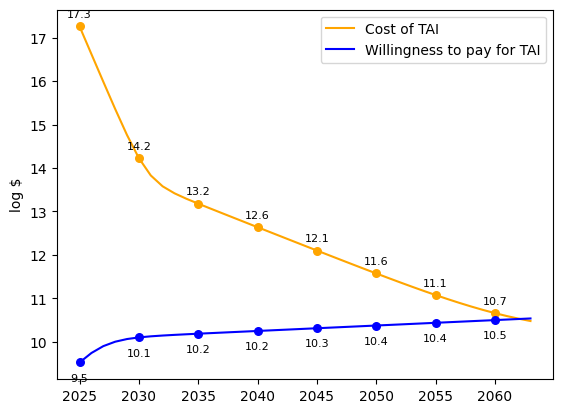

-
-
## SAMPLE RUN 27 ##

In this simulation:
* It takes 37.5 log FLOP (~31.6 thousand decillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 19.1 log FLOP (~11.6 quintillion) per 2025$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 23.6 log FLOP (~432.2 sextillion) per 2025$USD.
* We are initially willing to pay 9.6 log 2025$USD (~4.0 billion).
* This doubles every 1.8 year to a max of 0.031666% of GDP (initially ~7.9 billion 2025$USD).
* GDP grows at a rate of 1.026x per year.
---
2025 - TAI takes 37.5 logFLOP which costs 18.4 log 2025$USD to buy vs. WTP at 9.4 (buys 28.5 log FLOP or 28.5 2025-log-eFLOP)
2026 - TAI takes 37.2 logFLOP which costs 18.1 log 2025$USD to buy vs. WTP at 9.5 (buys 28.7 log FLOP or 29.0 2025-log-eFLOP)
2027 - TAI takes 37.0 logFLOP which costs 17.7 log 2025$USD to buy vs. WTP at 9.6 (buys 28.9 log FLOP or 29.4 2025-log-eFLOP)
2028 - TAI takes 36.7 logFLOP wh

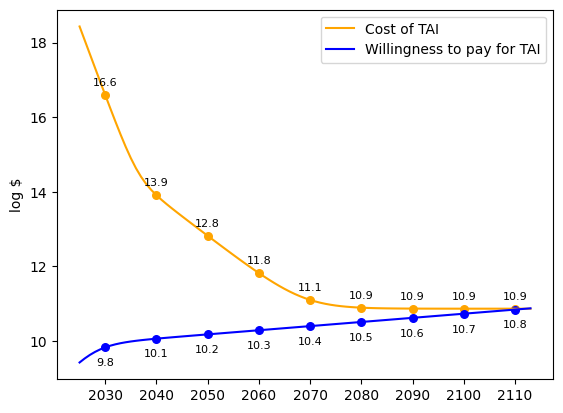

-
-
## SAMPLE RUN 28 ##

In this simulation:
* It takes 26.8 log FLOP (~631.0 septillion) for transformative capabilities.
* Every 1.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.6 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~13.5 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~405.3 million).
* This doubles every 0.5 year to a max of 0.003316% of GDP (initially ~827.7 million 2025$USD).
* GDP grows at a rate of 1.016x per year.
---
2025 - TAI takes 26.8 logFLOP which costs 8.4 log 2025$USD to buy vs. WTP at 8.4 (buys 26.9 log FLOP or 26.9 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 12 years (total delay 12 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 1

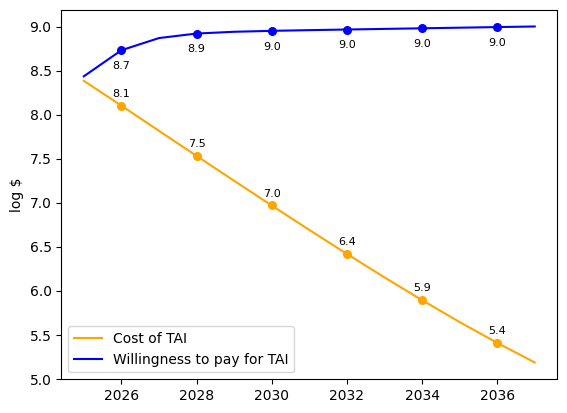

-
-
## SAMPLE RUN 29 ##

In this simulation:
* It takes 40.9 log FLOP (~79.4 million decillion) for transformative capabilities.
* Every 0.6 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 17.9 log FLOP (~715.0 quadrillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 24.6 log FLOP (~3.6 septillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~486.8 million).
* This doubles every 1.7 year to a max of 0.067523% of GDP (initially ~17.0 billion 2025$USD).
* GDP grows at a rate of 1.024x per year.
---
2025 - TAI takes 40.9 logFLOP which costs 23.0 log 2025$USD to buy vs. WTP at 8.7 (buys 26.5 log FLOP or 26.5 2025-log-eFLOP)
2026 - TAI takes 40.4 logFLOP which costs 22.4 log 2025$USD to buy vs. WTP at 8.9 (buys 26.8 log FLOP or 27.4 2025-log-eFLOP)
2027 - TAI takes 39.8 logFLOP which costs 21.7 log 2025$USD to buy vs. WTP at 9.0 (buys 27.1 log FLOP or 28.2 2025-log-eFLOP)
2028 - TAI takes 39.3 logFLOP w

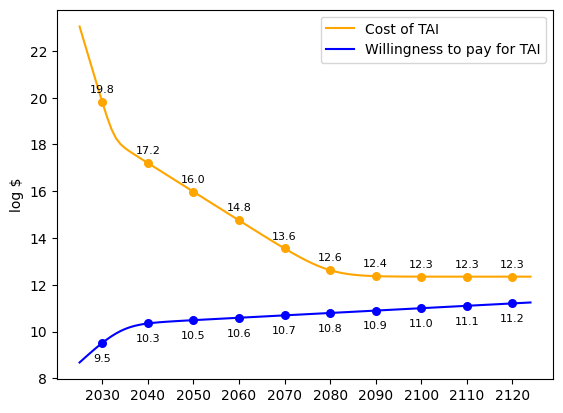

-
-
## SAMPLE RUN 30 ##

In this simulation:
* It takes 33.0 log FLOP (~1000.0 nonillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.2 log FLOP (~14.8 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 24.8 log FLOP (~5.8 septillion) per 2025$USD.
* We are initially willing to pay 9.5 log 2025$USD (~3.4 billion).
* This doubles every 1.5 year to a max of 0.028941% of GDP (initially ~7.3 billion 2025$USD).
* GDP grows at a rate of 1.02x per year.
---
2025 - TAI takes 33.0 logFLOP which costs 13.8 log 2025$USD to buy vs. WTP at 9.4 (buys 28.5 log FLOP or 28.5 2025-log-eFLOP)
2026 - TAI takes 32.6 logFLOP which costs 13.4 log 2025$USD to buy vs. WTP at 9.5 (buys 28.8 log FLOP or 29.1 2025-log-eFLOP)
2027 - TAI takes 32.3 logFLOP which costs 12.9 log 2025$USD to buy vs. WTP at 9.6 (buys 29.0 log FLOP or 29.7 2025-log-eFLOP)
2028 - TAI takes 32.0 logFLOP which costs 

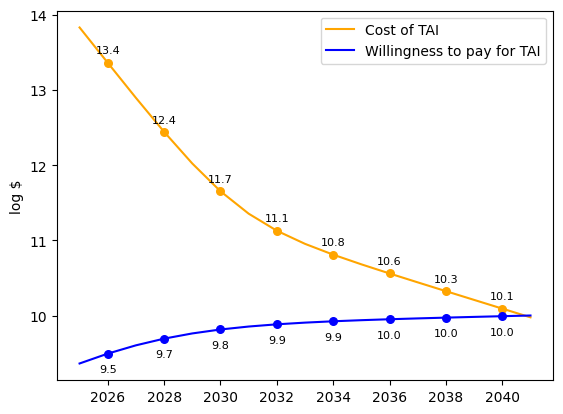

-
-
## SAMPLE RUN 31 ##

In this simulation:
* It takes 38.0 log FLOP (~100.0 thousand decillion) for transformative capabilities.
* Every 3.1 years algorithms get 2x better, with 3.0 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~2.1 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 24.3 log FLOP (~2.1 septillion) per 2025$USD.
* We are initially willing to pay 9.6 log 2025$USD (~4.4 billion).
* This doubles every 1.2 year to a max of 0.131818% of GDP (initially ~33.3 billion 2025$USD).
* GDP grows at a rate of 1.019x per year.
---
2025 - TAI takes 38.0 logFLOP which costs 19.7 log 2025$USD to buy vs. WTP at 9.6 (buys 27.9 log FLOP or 27.9 2025-log-eFLOP)
2026 - TAI takes 37.9 logFLOP which costs 19.5 log 2025$USD to buy vs. WTP at 9.8 (buys 28.2 log FLOP or 28.3 2025-log-eFLOP)
2027 - TAI takes 37.8 logFLOP which costs 19.3 log 2025$USD to buy vs. WTP at 10.0 (buys 28.5 log FLOP or 28.7 2025-log-eFLOP)
2028 - TAI takes 37.7 logFLOP 

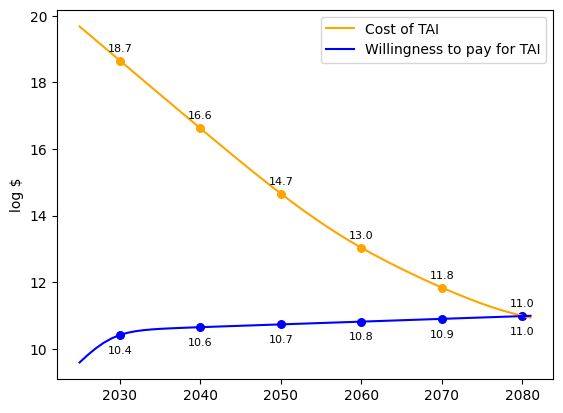

-
-
## SAMPLE RUN 32 ##

In this simulation:
* It takes 37.7 log FLOP (~50.1 thousand decillion) for transformative capabilities.
* Every 0.6 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 19.2 log FLOP (~16.6 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~3.0 sextillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.2 billion).
* This doubles every 1.3 year to a max of 0.171729% of GDP (initially ~43.5 billion 2025$USD).
* GDP grows at a rate of 1.016x per year.
---
2025 - TAI takes 37.7 logFLOP which costs 18.5 log 2025$USD to buy vs. WTP at 9.1 (buys 28.3 log FLOP or 28.3 2025-log-eFLOP)
2026 - TAI takes 37.2 logFLOP which costs 17.8 log 2025$USD to buy vs. WTP at 9.3 (buys 28.6 log FLOP or 29.2 2025-log-eFLOP)
2027 - TAI takes 36.7 logFLOP which costs 17.2 log 2025$USD to buy vs. WTP at 9.5 (buys 29.0 log FLOP or 30.0 2025-log-eFLOP)
2028 - TAI takes 36.2 logFLOP whi

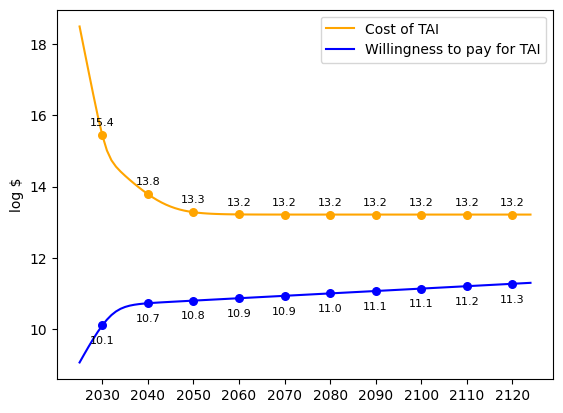

-
-
## SAMPLE RUN 33 ##

In this simulation:
* It takes 28.9 log FLOP (~79.4 octillion) for transformative capabilities.
* Every 1.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.7 log FLOP (~548.3 quadrillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 24.7 log FLOP (~5.3 septillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~690.2 million).
* This doubles every 0.9 year to a max of 0.021144% of GDP (initially ~5.3 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 28.9 logFLOP which costs 11.2 log 2025$USD to buy vs. WTP at 8.8 (buys 26.5 log FLOP or 26.5 2025-log-eFLOP)
2026 - TAI takes 28.7 logFLOP which costs 10.9 log 2025$USD to buy vs. WTP at 9.1 (buys 26.9 log FLOP or 27.1 2025-log-eFLOP)
2027 - TAI takes 28.5 logFLOP which costs 10.6 log 2025$USD to buy vs. WTP at 9.3 (buys 27.3 log FLOP or 27.7 2025-log-eFLOP)
2028 - TAI takes 28.4 logFLOP which cost

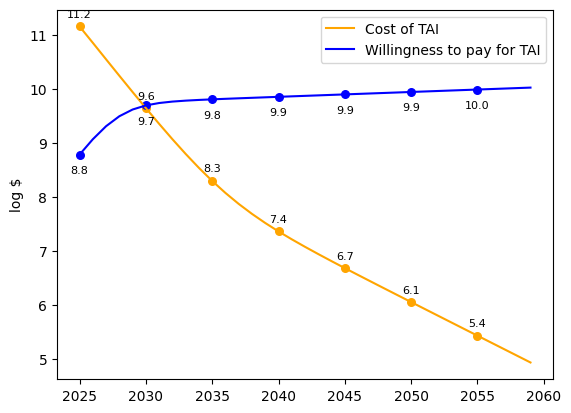

-
-
## SAMPLE RUN 34 ##

In this simulation:
* It takes 30.5 log FLOP (~3.2 nonillion) for transformative capabilities.
* Every 3.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.6 log FLOP (~399.9 quadrillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 24.0 log FLOP (~964.6 sextillion) per 2025$USD.
* We are initially willing to pay 8.3 log 2025$USD (~197.1 million).
* This doubles every 0.6 year to a max of 0.063806% of GDP (initially ~15.9 billion 2025$USD).
* GDP grows at a rate of 1.016x per year.
---
2025 - TAI takes 30.5 logFLOP which costs 12.9 log 2025$USD to buy vs. WTP at 8.3 (buys 25.9 log FLOP or 25.9 2025-log-eFLOP)
2026 - TAI takes 30.4 logFLOP which costs 12.7 log 2025$USD to buy vs. WTP at 8.8 (buys 26.5 log FLOP or 26.6 2025-log-eFLOP)
2027 - TAI takes 30.3 logFLOP which costs 12.5 log 2025$USD to buy vs. WTP at 9.3 (buys 27.1 log FLOP or 27.3 2025-log-eFLOP)
2028 - TAI takes 30.3 logFLOP which co

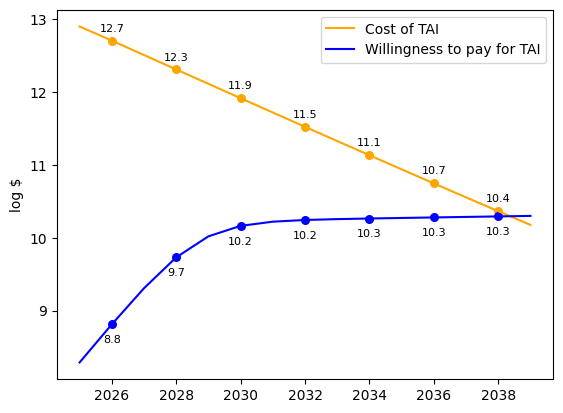

-
-
## SAMPLE RUN 35 ##

In this simulation:
* It takes 29.8 log FLOP (~631.0 octillion) for transformative capabilities.
* Every 2.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.0 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 24.0 log FLOP (~1.0 septillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~343.0 million).
* This doubles every 1.5 year to a max of 0.009822% of GDP (initially ~2.5 billion 2025$USD).
* GDP grows at a rate of 1.024x per year.
---
2025 - TAI takes 29.8 logFLOP which costs 11.3 log 2025$USD to buy vs. WTP at 8.5 (buys 27.0 log FLOP or 27.0 2025-log-eFLOP)
2026 - TAI takes 29.7 logFLOP which costs 11.1 log 2025$USD to buy vs. WTP at 8.6 (buys 27.2 log FLOP or 27.3 2025-log-eFLOP)
2027 - TAI takes 29.6 logFLOP which costs 10.9 log 2025$USD to buy vs. WTP at 8.8 (buys 27.5 log FLOP or 27.7 2025-log-eFLOP)
2028 - TAI takes 29.5 logFLOP which costs

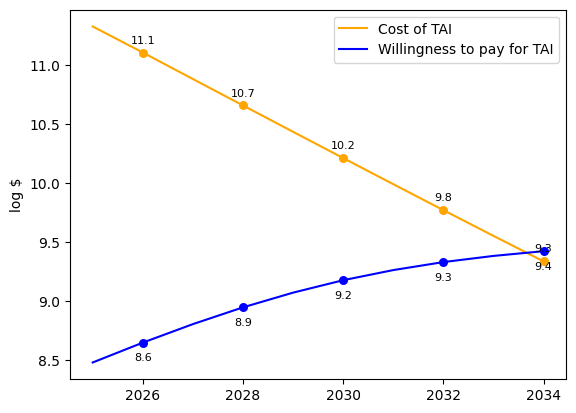

-
-
## SAMPLE RUN 36 ##

In this simulation:
* It takes 38.6 log FLOP (~398.1 thousand decillion) for transformative capabilities.
* Every 0.4 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 17.8 log FLOP (~676.1 quadrillion) per 2025$USD.
* Every 2.0 years they get 2x cheaper, to a maximum of 24.4 log FLOP (~2.3 septillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~467.6 million).
* This doubles every 1.9 year to a max of 0.0279% of GDP (initially ~7.0 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 38.6 logFLOP which costs 20.8 log 2025$USD to buy vs. WTP at 8.6 (buys 26.5 log FLOP or 26.5 2025-log-eFLOP)
2026 - TAI takes 37.9 logFLOP which costs 19.9 log 2025$USD to buy vs. WTP at 8.8 (buys 26.8 log FLOP or 27.5 2025-log-eFLOP)
2027 - TAI takes 37.2 logFLOP which costs 19.0 log 2025$USD to buy vs. WTP at 8.9 (buys 27.1 log FLOP or 28.5 2025-log-eFLOP)
2028 - TAI takes 36.5 logFLOP wh

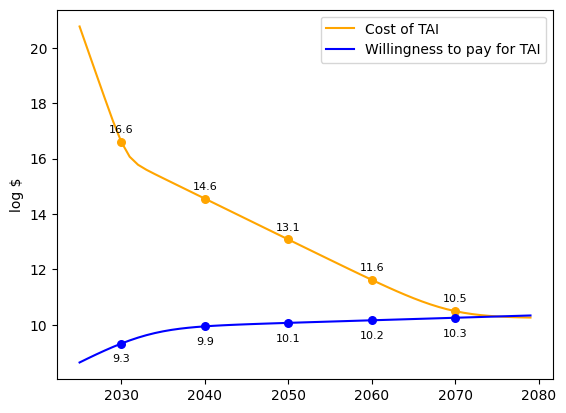

-
-
## SAMPLE RUN 37 ##

In this simulation:
* It takes 36.3 log FLOP (~2.0 thousand decillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.7 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~3.4 sextillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~463.2 million).
* This doubles every 0.9 year to a max of 0.02432% of GDP (initially ~6.1 billion 2025$USD).
* GDP grows at a rate of 1.023x per year.
---
2025 - TAI takes 36.3 logFLOP which costs 17.9 log 2025$USD to buy vs. WTP at 8.6 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
2026 - TAI takes 36.1 logFLOP which costs 17.5 log 2025$USD to buy vs. WTP at 8.9 (buys 27.5 log FLOP or 27.7 2025-log-eFLOP)
2027 - TAI takes 35.8 logFLOP which costs 17.1 log 2025$USD to buy vs. WTP at 9.2 (buys 27.9 log FLOP or 28.4 2025-log-eFLOP)
2028 - TAI takes 35.6 logFLOP which

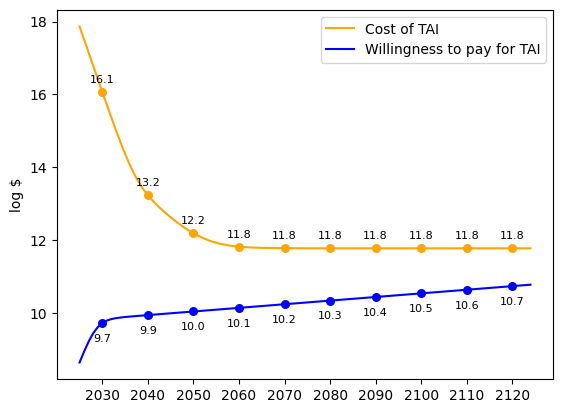

-
-
## SAMPLE RUN 38 ##

In this simulation:
* It takes 28.6 log FLOP (~39.8 octillion) for transformative capabilities.
* Every 2.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~4.6 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 19.3 log FLOP (~21.5 quintillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~977.9 million).
* This doubles every 1.0 year to a max of 0.17614% of GDP (initially ~44.3 billion 2025$USD).
* GDP grows at a rate of 1.027x per year.
---
2025 - TAI takes 28.6 logFLOP which costs 10.0 log 2025$USD to buy vs. WTP at 9.0 (buys 27.6 log FLOP or 27.6 2025-log-eFLOP)
2026 - TAI takes 28.5 logFLOP which costs 9.8 log 2025$USD to buy vs. WTP at 9.3 (buys 27.9 log FLOP or 28.1 2025-log-eFLOP)
2027 - TAI takes 28.4 logFLOP which costs 9.6 log 2025$USD to buy vs. WTP at 9.5 (buys 28.3 log FLOP or 28.6 2025-log-eFLOP)
2028 - TAI takes 28.3 logFLOP which costs 

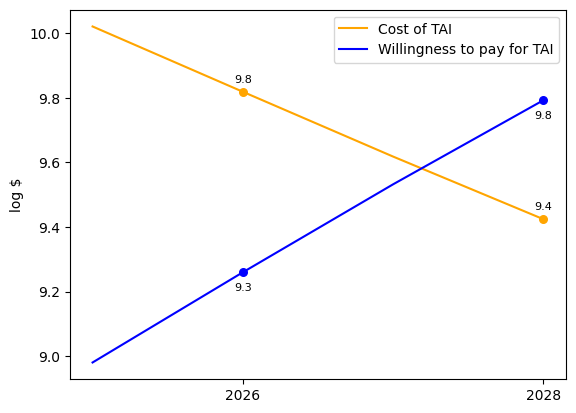

-
-
## SAMPLE RUN 39 ##

In this simulation:
* It takes 27.7 log FLOP (~5.0 octillion) for transformative capabilities.
* Every 1.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~5.5 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 25.6 log FLOP (~44.0 septillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~753.6 million).
* This doubles every 0.7 year to a max of 0.003664% of GDP (initially ~929.6 million 2025$USD).
* GDP grows at a rate of 1.022x per year.
---
2025 - TAI takes 27.7 logFLOP which costs 9.0 log 2025$USD to buy vs. WTP at 8.6 (buys 27.4 log FLOP or 27.4 2025-log-eFLOP)
2026 - TAI takes 27.5 logFLOP which costs 8.7 log 2025$USD to buy vs. WTP at 8.8 (buys 27.7 log FLOP or 27.8 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1728 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6988 -> Nonscaling delay occured
-- -- this delay is 10 year

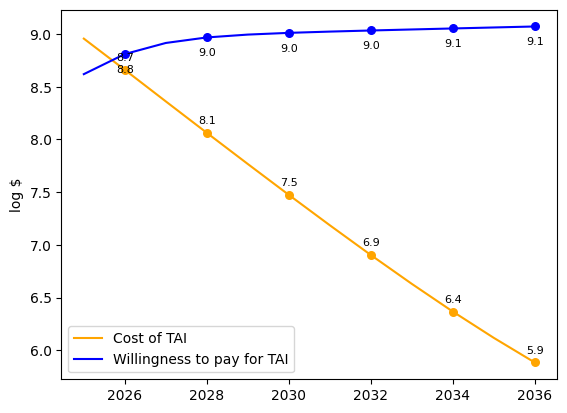

-
-
## SAMPLE RUN 40 ##

In this simulation:
* It takes 42.4 log FLOP (~2.5 billion decillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 5 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~2.9 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~23.4 sextillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~684.2 million).
* This doubles every 2.2 year to a max of 0.019435% of GDP (initially ~4.9 billion 2025$USD).
* GDP grows at a rate of 1.014x per year.
---
2025 - TAI takes 42.4 logFLOP which costs 23.9 log 2025$USD to buy vs. WTP at 8.8 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
2026 - TAI takes 42.0 logFLOP which costs 23.5 log 2025$USD to buy vs. WTP at 8.9 (buys 27.5 log FLOP or 27.8 2025-log-eFLOP)
2027 - TAI takes 41.7 logFLOP which costs 23.0 log 2025$USD to buy vs. WTP at 9.0 (buys 27.7 log FLOP or 28.4 2025-log-eFLOP)
2028 - TAI takes 41.3 logFLOP whic

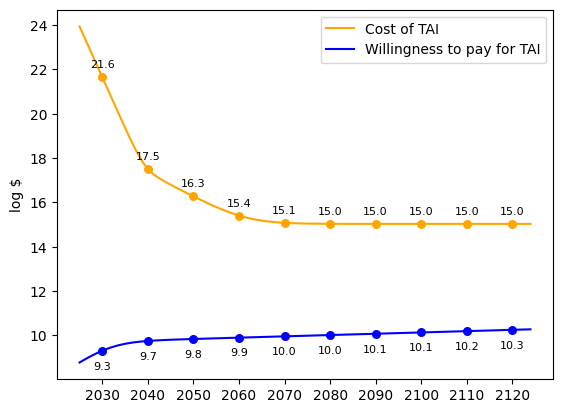

-
-
## SAMPLE RUN 41 ##

In this simulation:
* It takes 26.6 log FLOP (~398.1 septillion) for transformative capabilities.
* Every 1.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.9 log FLOP (~890.9 quadrillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~119.3 sextillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~548.1 million).
* This doubles every 0.8 year to a max of 0.016588% of GDP (initially ~4.2 billion 2025$USD).
* GDP grows at a rate of 1.012x per year.
---
2025 - TAI takes 26.6 logFLOP which costs 8.7 log 2025$USD to buy vs. WTP at 8.7 (buys 26.6 log FLOP or 26.6 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 7 years (total delay 7 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 7 

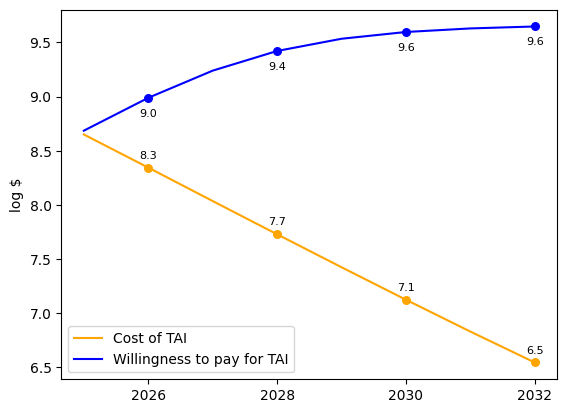

-
-
## SAMPLE RUN 42 ##

In this simulation:
* It takes 30.7 log FLOP (~5.0 nonillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.9 log FLOP (~873.5 quadrillion) per 2025$USD.
* Every 2.0 years they get 2x cheaper, to a maximum of 23.6 log FLOP (~380.0 sextillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~482.0 million).
* This doubles every 0.8 year to a max of 0.050152% of GDP (initially ~12.6 billion 2025$USD).
* GDP grows at a rate of 1.029x per year.
---
2025 - TAI takes 30.7 logFLOP which costs 12.8 log 2025$USD to buy vs. WTP at 8.7 (buys 26.6 log FLOP or 26.6 2025-log-eFLOP)
2026 - TAI takes 30.5 logFLOP which costs 12.4 log 2025$USD to buy vs. WTP at 9.0 (buys 27.1 log FLOP or 27.4 2025-log-eFLOP)
2027 - TAI takes 30.2 logFLOP which costs 12.0 log 2025$USD to buy vs. WTP at 9.4 (buys 27.6 log FLOP or 28.1 2025-log-eFLOP)
2028 - TAI takes 30.0 logFLOP which co

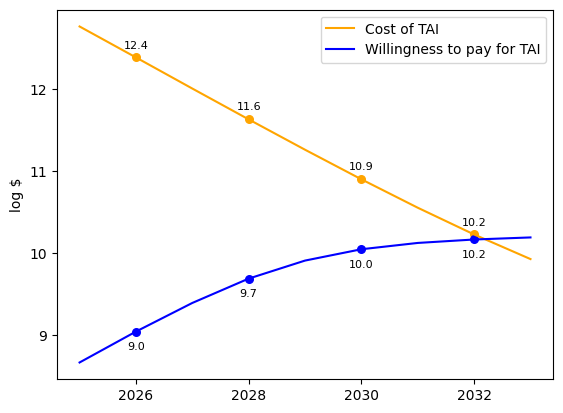

-
-
## SAMPLE RUN 43 ##

In this simulation:
* It takes 27.8 log FLOP (~6.3 octillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~2.2 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 25.0 log FLOP (~10.8 septillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~981.7 million).
* This doubles every 0.4 year to a max of 0.213147% of GDP (initially ~53.6 billion 2025$USD).
* GDP grows at a rate of 1.023x per year.
---
2025 - TAI takes 27.8 logFLOP which costs 9.5 log 2025$USD to buy vs. WTP at 9.0 (buys 27.3 log FLOP or 27.3 2025-log-eFLOP)
2026 - TAI takes 27.5 logFLOP which costs 9.1 log 2025$USD to buy vs. WTP at 9.7 (buys 28.2 log FLOP or 28.4 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1728 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.6988 -> Nonscaling delay occured
-- -- this delay is 10 years

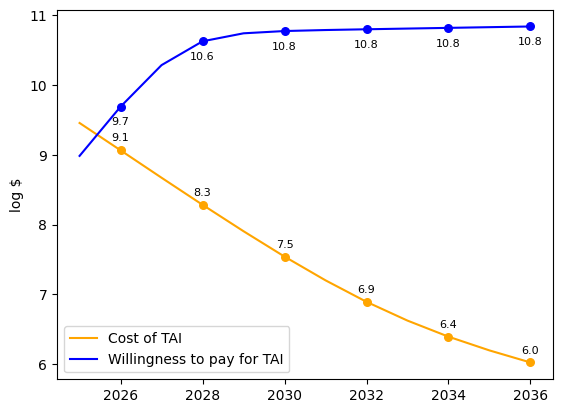

-
-
## SAMPLE RUN 44 ##

In this simulation:
* It takes 33.5 log FLOP (~3.2 decillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.9 log FLOP (~817.2 quadrillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 26.9 log FLOP (~847.4 septillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~728.6 million).
* This doubles every 1.1 year to a max of 0.035114% of GDP (initially ~8.8 billion 2025$USD).
* GDP grows at a rate of 1.026x per year.
---
2025 - TAI takes 33.5 logFLOP which costs 15.6 log 2025$USD to buy vs. WTP at 8.8 (buys 26.7 log FLOP or 26.7 2025-log-eFLOP)
2026 - TAI takes 33.1 logFLOP which costs 15.1 log 2025$USD to buy vs. WTP at 9.1 (buys 27.1 log FLOP or 27.5 2025-log-eFLOP)
2027 - TAI takes 32.7 logFLOP which costs 14.5 log 2025$USD to buy vs. WTP at 9.3 (buys 27.5 log FLOP or 28.2 2025-log-eFLOP)
2028 - TAI takes 32.3 logFLOP which cos

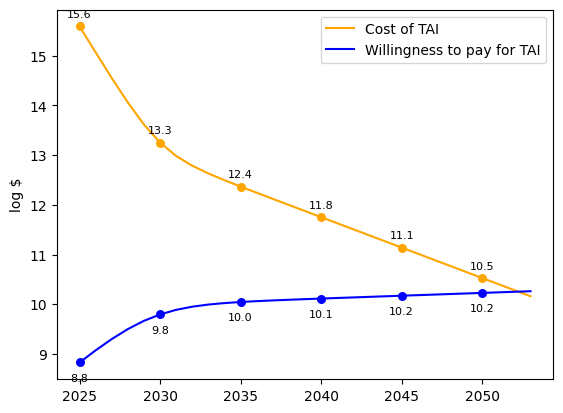

-
-
## SAMPLE RUN 45 ##

In this simulation:
* It takes 30.0 log FLOP (~1.0 nonillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.8 log FLOP (~673.9 quadrillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 24.5 log FLOP (~3.0 septillion) per 2025$USD.
* We are initially willing to pay 8.4 log 2025$USD (~243.0 million).
* This doubles every 0.4 year to a max of 0.029734% of GDP (initially ~7.4 billion 2025$USD).
* GDP grows at a rate of 1.026x per year.
---
2025 - TAI takes 30.0 logFLOP which costs 12.2 log 2025$USD to buy vs. WTP at 8.4 (buys 26.2 log FLOP or 26.2 2025-log-eFLOP)
2026 - TAI takes 29.8 logFLOP which costs 11.8 log 2025$USD to buy vs. WTP at 9.0 (buys 27.0 log FLOP or 27.2 2025-log-eFLOP)
2027 - TAI takes 29.5 logFLOP which costs 11.4 log 2025$USD to buy vs. WTP at 9.5 (buys 27.6 log FLOP or 28.1 2025-log-eFLOP)
2028 - TAI takes 29.3 logFLOP which costs

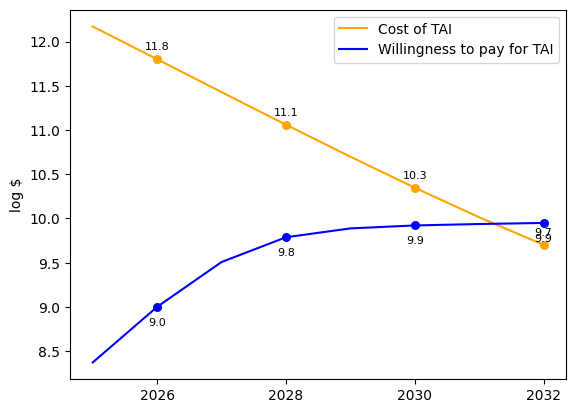

-
-
## SAMPLE RUN 46 ##

In this simulation:
* It takes 26.2 log FLOP (~158.5 septillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~4.0 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 21.0 log FLOP (~1.1 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~389.3 million).
* This doubles every 2.5 year to a max of 0.006906% of GDP (initially ~1.7 billion 2025$USD).
* GDP grows at a rate of 1.029x per year.
---
2025 - TAI takes 26.2 logFLOP which costs 7.6 log 2025$USD to buy vs. WTP at 8.5 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- data p_nonscaling_issue p=0.5 -> Nonscaling delay occured
-- -- this delay is 1 years (total delay 5 year

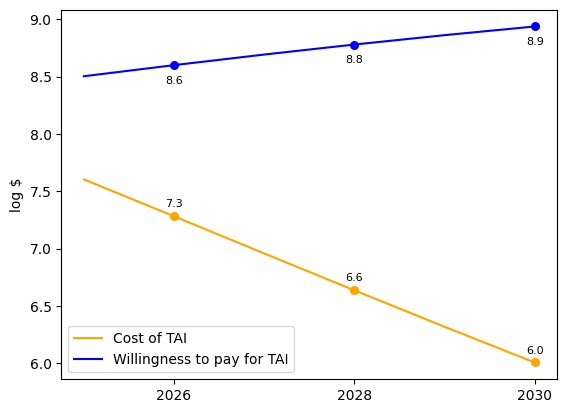

-
-
## SAMPLE RUN 47 ##

In this simulation:
* It takes 27.7 log FLOP (~5.0 octillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~2.0 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~120.9 sextillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~614.0 million).
* This doubles every 0.9 year to a max of 0.090634% of GDP (initially ~22.8 billion 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 27.7 logFLOP which costs 9.4 log 2025$USD to buy vs. WTP at 8.8 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
2026 - TAI takes 27.5 logFLOP which costs 9.1 log 2025$USD to buy vs. WTP at 9.1 (buys 27.5 log FLOP or 27.7 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1728 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- infra p_nonscaling_issue p=0.6988 -> Nonscali

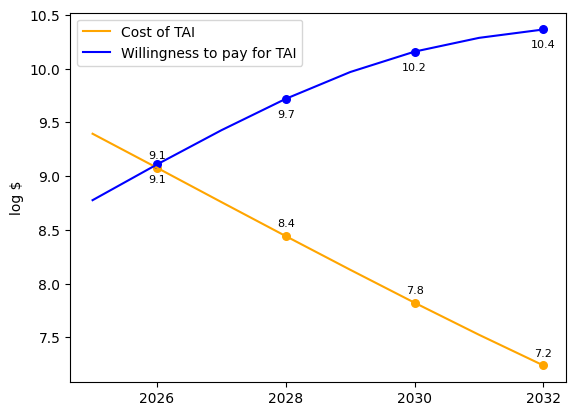

-
-
## SAMPLE RUN 48 ##

In this simulation:
* It takes 24.6 log FLOP (~4.0 septillion) for transformative capabilities.
* Every 1.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.6 quintillion) per 2025$USD.
* Every 1.9 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~101.5 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~387.7 million).
* This doubles every 1.5 year to a max of 0.006896% of GDP (initially ~1.7 billion 2025$USD).
* GDP grows at a rate of 1.02x per year.
---
2025 - TAI takes 24.6 logFLOP which costs 6.4 log 2025$USD to buy vs. WTP at 8.5 (buys 26.7 log FLOP or 26.7 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.5 -> Nonscaling issue did not occur
--- /!\ TAI CREATED in 2025
-
-
## SAMPLE RUN 49 ##

In this simulation:
* It takes 33

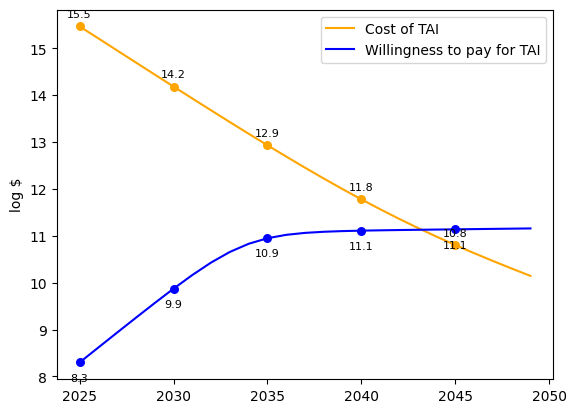

-
-
## SAMPLE RUN 50 ##

In this simulation:
* It takes 29.4 log FLOP (~251.2 octillion) for transformative capabilities.
* Every 2.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.1 log FLOP (~11.3 quintillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~175.9 sextillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~605.9 million).
* This doubles every 1.1 year to a max of 0.060875% of GDP (initially ~15.2 billion 2025$USD).
* GDP grows at a rate of 1.023x per year.
---
2025 - TAI takes 29.4 logFLOP which costs 10.3 log 2025$USD to buy vs. WTP at 8.8 (buys 27.8 log FLOP or 27.8 2025-log-eFLOP)
2026 - TAI takes 29.3 logFLOP which costs 10.1 log 2025$USD to buy vs. WTP at 9.0 (buys 28.2 log FLOP or 28.4 2025-log-eFLOP)
2027 - TAI takes 29.1 logFLOP which costs 9.8 log 2025$USD to buy vs. WTP at 9.3 (buys 28.6 log FLOP or 28.9 2025-log-eFLOP)
2028 - TAI takes 29.0 logFLOP which co

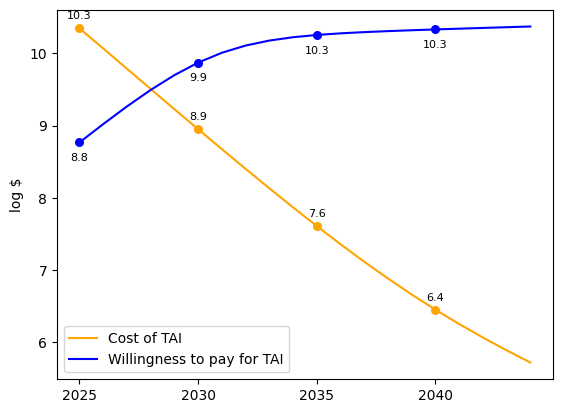

-
-
## SAMPLE RUN 51 ##

In this simulation:
* It takes 39.5 log FLOP (~3.2 million decillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 2.8 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~4.3 quintillion) per 2025$USD.
* Every 2.0 years they get 2x cheaper, to a maximum of 24.1 log FLOP (~1.3 septillion) per 2025$USD.
* We are initially willing to pay 9.3 log 2025$USD (~1.8 billion).
* This doubles every 0.9 year to a max of 0.073802% of GDP (initially ~18.6 billion 2025$USD).
* GDP grows at a rate of 1.019x per year.
---
2025 - TAI takes 39.5 logFLOP which costs 20.9 log 2025$USD to buy vs. WTP at 9.2 (buys 27.9 log FLOP or 27.9 2025-log-eFLOP)
2026 - TAI takes 39.2 logFLOP which costs 20.4 log 2025$USD to buy vs. WTP at 9.5 (buys 28.3 log FLOP or 28.6 2025-log-eFLOP)
2027 - TAI takes 38.9 logFLOP which costs 19.9 log 2025$USD to buy vs. WTP at 9.8 (buys 28.7 log FLOP or 29.4 2025-log-eFLOP)
2028 - TAI takes 38.5 logFLOP whic

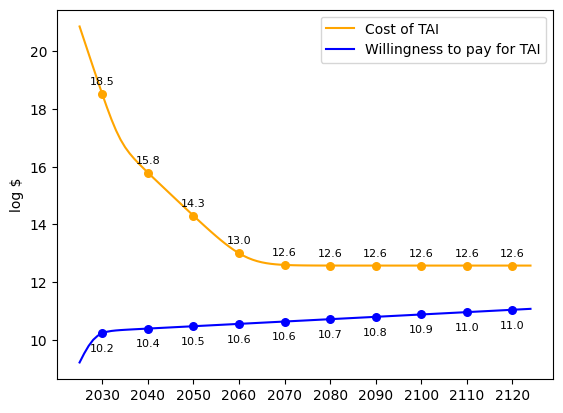

-
-
## SAMPLE RUN 52 ##

In this simulation:
* It takes 35.7 log FLOP (~501.2 decillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~2.2 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 23.7 log FLOP (~490.8 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~988.8 million).
* This doubles every 0.8 year to a max of 0.351684% of GDP (initially ~88.6 billion 2025$USD).
* GDP grows at a rate of 1.009x per year.
---
2025 - TAI takes 35.7 logFLOP which costs 17.4 log 2025$USD to buy vs. WTP at 9.0 (buys 27.3 log FLOP or 27.3 2025-log-eFLOP)
2026 - TAI takes 35.5 logFLOP which costs 17.0 log 2025$USD to buy vs. WTP at 9.3 (buys 27.8 log FLOP or 28.0 2025-log-eFLOP)
2027 - TAI takes 35.3 logFLOP which costs 16.7 log 2025$USD to buy vs. WTP at 9.7 (buys 28.3 log FLOP or 28.7 2025-log-eFLOP)
2028 - TAI takes 35.1 logFLOP which co

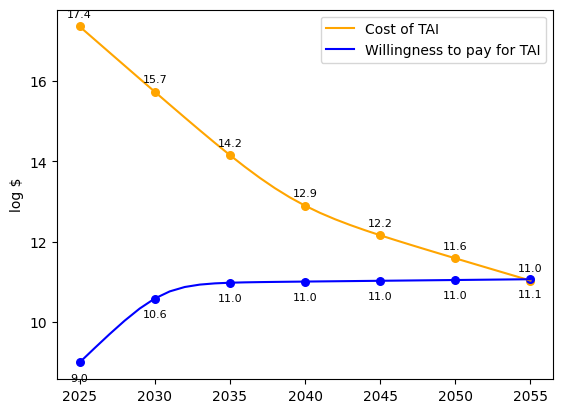

-
-
## SAMPLE RUN 53 ##

In this simulation:
* It takes 33.8 log FLOP (~6.3 decillion) for transformative capabilities.
* Every 1.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~7.3 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 23.8 log FLOP (~574.8 sextillion) per 2025$USD.
* We are initially willing to pay 9.6 log 2025$USD (~4.1 billion).
* This doubles every 0.6 year to a max of 0.028055% of GDP (initially ~7.1 billion 2025$USD).
* GDP grows at a rate of 1.017x per year.
---
2025 - TAI takes 33.8 logFLOP which costs 14.9 log 2025$USD to buy vs. WTP at 9.4 (buys 28.3 log FLOP or 28.3 2025-log-eFLOP)
2026 - TAI takes 33.6 logFLOP which costs 14.6 log 2025$USD to buy vs. WTP at 9.7 (buys 28.7 log FLOP or 28.8 2025-log-eFLOP)
2027 - TAI takes 33.5 logFLOP which costs 14.4 log 2025$USD to buy vs. WTP at 9.8 (buys 28.9 log FLOP or 29.2 2025-log-eFLOP)
2028 - TAI takes 33.3 logFLOP which costs 1

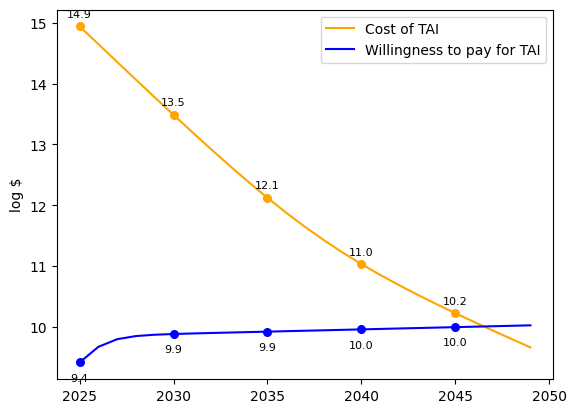

In [16]:
for i in range(50):
    print('-')
    print('-')
    print('## SAMPLE RUN {} ##'.format(i + 3 + 1))
    define_tai_timeline_event(variables, verbose=True)

In [17]:
print('File last ran: {}'.format(dt.now()))

File last ran: 2024-08-31 10:35:58.837076
